In [195]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from IPython.display import display
import matplotlib.font_manager as fm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.optimize import minimize
from thefuzz import process
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from keras.models import Model
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
import joblib
from joblib import load
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False    

In [2]:
# 显示所有列
pd.options.display.max_columns = None
# 显示所有行
pd.options.display.max_rows = None

In [236]:
#从这个地方更换全部路径！
state = pd.read_csv("G:\桌面文件\data\state_utf8.csv")
city = pd.read_csv("G:\桌面文件\data\city_utf8.csv")
population_city = pd.read_csv("G:\\桌面文件\\data\\final_city_population_data.csv")

In [4]:
# print(state.info())
# print('-'*80)
# print(city.info())

In [5]:
# print(state['地域'].unique())

In [6]:
#优先处理state数据
##添加省份人口数据 然后将未知数据平均划分入整体数据
population_list =[
    {'地域': '北京市', '人口数量（万人）': 2189.3},
    {'地域': '天津市', '人口数量（万人）': 1386.6},
    {'地域': '河北省', '人口数量（万人）': 7461.0},
    {'地域': '山西省', '人口数量（万人）': 3491.6},
    {'地域': '内蒙古自治区', '人口数量（万人）': 2404.9},
    {'地域': '辽宁省', '人口数量（万人）': 4259.1},
    {'地域': '吉林省', '人口数量（万人）': 2407.3},
    {'地域': '黑龙江省', '人口数量（万人）': 3185.0},
    {'地域': '上海市', '人口数量（万人）': 2487.1},
    {'地域': '江苏省', '人口数量（万人）': 8474.8},
    {'地域': '浙江省', '人口数量（万人）': 6456.8},
    {'地域': '安徽省', '人口数量（万人）': 6102.7},
    {'地域': '福建省', '人口数量（万人）': 4154.0},
    {'地域': '江西省', '人口数量（万人）': 4518.9},
    {'地域': '山东省', '人口数量（万人）': 10152.7},
    {'地域': '河南省', '人口数量（万人）': 9936.6},
    {'地域': '湖北省', '人口数量（万人）': 5775.3},
    {'地域': '湖南省', '人口数量（万人）': 6644.5},
    {'地域': '广东省', '人口数量（万人）': 12601.3},
    {'地域': '广西壮族自治区', '人口数量（万人）': 5012.7},
    {'地域': '海南省', '人口数量（万人）': 1008.1},
    {'地域': '重庆市', '人口数量（万人）': 3205.4},
    {'地域': '四川省', '人口数量（万人）': 8367.5},
    {'地域': '贵州省', '人口数量（万人）': 3856.2},
    {'地域': '云南省', '人口数量（万人）': 4720.9},
    {'地域': '西藏自治区', '人口数量（万人）': 364.8},
    {'地域': '陕西省', '人口数量（万人）': 3952.9},
    {'地域': '甘肃省', '人口数量（万人）': 2503.7},
    {'地域': '青海省', '人口数量（万人）': 592.4},
    {'地域': '宁夏回族自治区', '人口数量（万人）': 720.2},
    {'地域': '新疆维吾尔自治区', '人口数量（万人）': 2585.2},
    {'地域': '台湾省', '人口数量（万人）': 2356.9},
    {'地域': '香港特别行政区', '人口数量（万人）': 747.4},
    {'地域': '澳门特别行政区', '人口数量（万人）': 68.3}
]

population_df = pd.DataFrame(population_list)

state_filtered = state[~state['地域'].isin(['未知','中国未知'])]

state_merged = state_filtered.merge(population_df, on='地域', how='left')

In [7]:
total_population = state_merged['人口数量（万人）'].sum()

state_merged['人口占比'] = (state_merged['人口数量（万人）'] / total_population)
# state_merged['人口占比'] = state_merged['人口占比'].map('{:.2f}%'.format)

# print(total_population)
# print(state_merged)

In [8]:
unknow_data = state[state['地域'].isin(['未知','中国未知'])]
total_unknow_data = unknow_data.sum(numeric_only=True)

for col in total_unknow_data.index:
    if col in state_merged.columns and pd.api.types.is_numeric_dtype(state_merged[col]):
        state_merged[f'调整后{col}'] = state_merged[col] +(state_merged['人口占比'] * total_unknow_data[col])
# display(state_merged)      

In [9]:
org_col = [col for col in total_unknow_data.index if col in state_merged.columns]

state_merged.drop(columns=org_col, inplace=True)
state = state_merged

# display(state)

In [10]:
columns_to_convert = ['曝光次数', '点击次数', '花费', '下单金额', '点击率', '目标转化率']

for col in columns_to_convert:
    state[col] = state[col].astype(str).str.replace(r'[^\d.-]', '', regex=True)
    state[col] = pd.to_numeric(state[col], errors='coerce')

# print(state[columns_to_convert].dtypes)

In [11]:
state['调整后目标转化量'] = state['调整后目标转化量'].astype(int)

state['每万人次曝光量'] = state['曝光次数'] / state['人口数量（万人）']
state['每万人次点击率'] = state['点击次数'] / state['人口数量（万人）']
state['万人次点击量'] = state['每万人次曝光量'] * state['每万人次点击率']
state['每万人次转化量'] = state['万人次点击量'] * (state['目标转化率'] / 10)

state['每万人次下单金额'] = state['下单金额'] / state['人口数量（万人）']
state['每万人次花费'] = state['花费'] / state['人口数量（万人）']

state['点击均价'] = state['花费'] / state['点击次数']

state['每次下单金额'] = state['下单金额'] / state['调整后目标转化量']

state['每人次花费'] = state['花费'] / (state['人口数量（万人）'] * 10000)
state['每人次曝光量'] = state['曝光次数'] / (state['人口数量（万人）'] * 10000)

state['每万次曝光花费'] = state['花费'] / (state['曝光次数'] / 10000)
state['每万次点击花费'] = state['花费'] / (state['点击次数'] / 10000)
state['每万次转化花费'] = state['花费'] / (state['调整后目标转化量'] / 10000)

state['每万次曝光产生的销售额'] = (state['下单金额'] / state['曝光次数']) * 10000
state['每万次点击产生的销售额'] = (state['下单金额'] / state['点击次数']) * 10000
state['每万次转化产生的销售额'] = (state['下单金额'] / state['调整后目标转化量']) * 10000

state['调整后下单ROI'] = 2 - state['调整后下单ROI']

state.replace([np.inf, -np.inf], np.nan, inplace=True)
state.fillna(0, inplace=True)

total_exposure = state['曝光次数'].sum()

In [12]:
south_state = [ '上海市', '江苏省', '浙江省', '安徽省', '福建省', '江西省', 
     '湖北省', '湖南省', '广东省', '广西壮族自治区', '海南省', '重庆市',
    '四川省', '贵州省', '云南省']

state['南北方_南0_北1'] = np.where(state['地域'].isin(south_state),0, 1)

# print(state['南北方_南0_北1'])

In [13]:
#南北方数据分析对比
columns_to_convert = ['曝光次数', '点击次数', '花费', '下单金额']

for col in columns_to_convert:
    state[col] = state[col].astype(str).str.replace(',','')
    state[col] = pd.to_numeric(state[col], errors='coerce')

# print(state[columns_to_convert].dtypes)

median_cols = [
    '调整后目标转化成本', '调整后下单ROI', '调整后点击均价', '调整后下单单价', 
    '调整后下单ROI（点击归因）', '每万人次曝光量', '每万人次点击率', '每万人次转化量', 
    '每万人次下单金额', '每万人次花费', '点击均价', '目标转化率',
    '每次下单金额', '每人次花费', '每人次曝光量', '每万次曝光花费',
    '每万次点击花费','每万次转化花费','调整后下单ROI','每万次曝光产生的销售额','每万次点击产生的销售额',
    '每万次转化产生的销售额','万人次点击量'
]

sum_cols = [col for col in state.columns if col not in median_cols + ['南北方_南0_北1']]

agg_dict = {col: 'median' for col in median_cols}
agg_dict.update({col: 'sum' for col in sum_cols})

grouped_df = state.groupby('南北方_南0_北1').agg(agg_dict)

north_data = grouped_df.loc[1]
south_data =grouped_df.loc[0]

compare_NS_df = pd.DataFrame({
    '北方总和':north_data,
    '南方总和':south_data
})

compare_NS_df = compare_NS_df.drop(['地域'], axis=0)


In [14]:
desired_order = [
    '花费', '下单金额', '曝光次数', '点击次数', '点击率', '点击均价', '调整后点击均价', '目标转化率', '调整后目标转化量',
    '调整后目标转化成本', '调整后下单单价', '每次下单金额', '调整后下单ROI', '人口数量（万人）', '人口占比',
    '每万人次曝光量', '每万人次点击率','万人次点击量', '每万人次转化量', '每万人次下单金额', '每万人次花费',
    '每万次曝光花费', '每万次点击花费', '每万次转化花费', '每人次花费', '每人次曝光量', 
    '每万次曝光产生的销售额', '每万次点击产生的销售额', '每万次转化产生的销售额'
]

compare_NS_df = compare_NS_df.reindex(desired_order)
display(compare_NS_df)

,北方总和,南方总和
花费,49053.09,96699.77
下单金额,44733.59,86648.4
曝光次数,1120919,2022742
点击次数,20470,34536
点击率,30.83,25.74
点击均价,2.416667,2.810995
调整后点击均价,2.507345,2.906383
目标转化率,6.42,7.38
调整后目标转化量,1334,2570
调整后目标转化成本,37.122025,39.859334


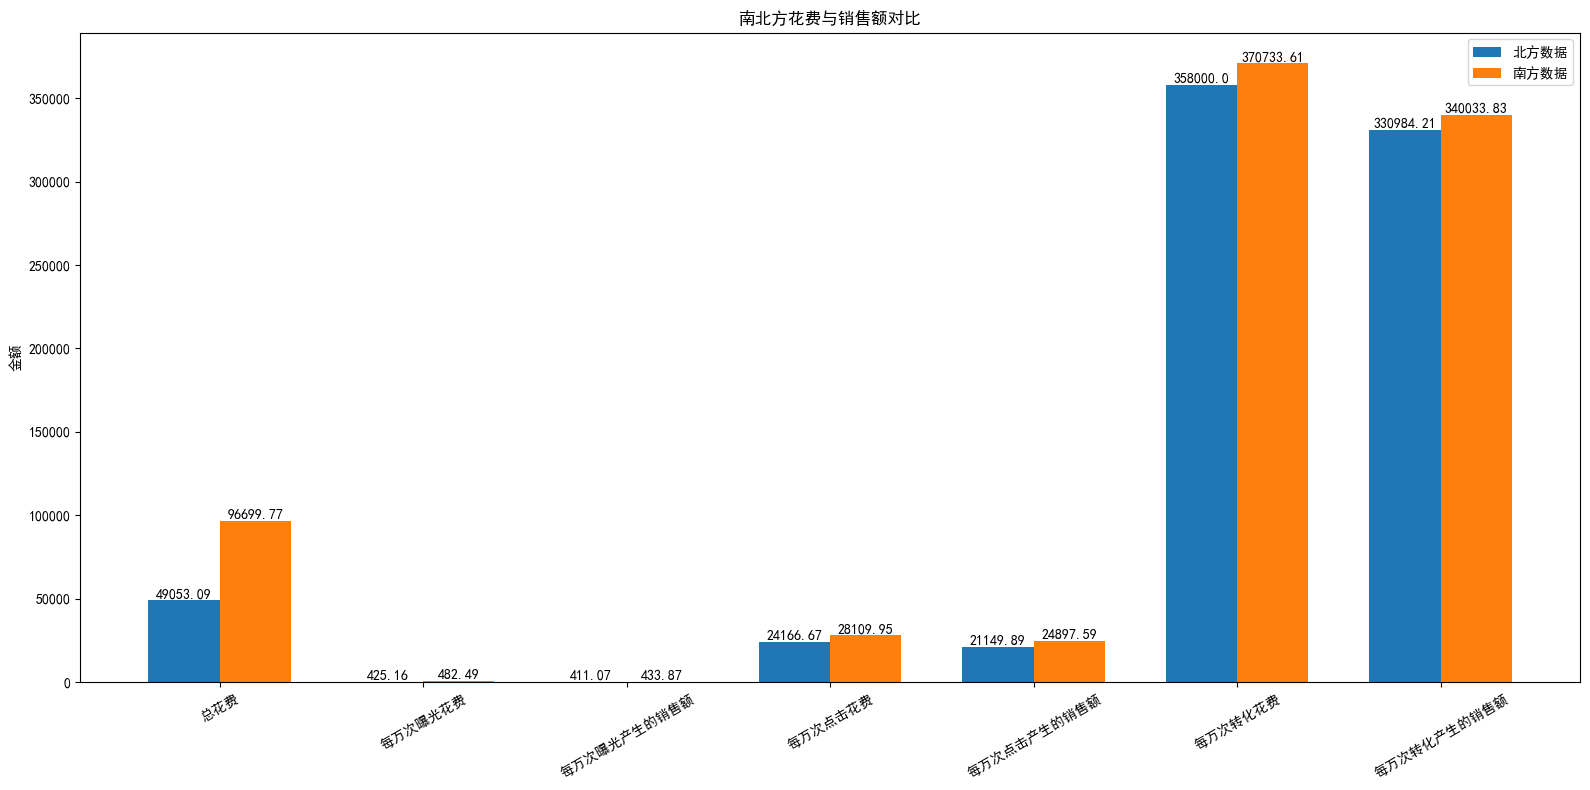

In [15]:
#花费与销售额分析

plt.figure(figsize=(16,8))

labels = ['总花费', '每万次曝光花费', '每万次曝光产生的销售额','每万次点击花费', '每万次点击产生的销售额','每万次转化花费', 
          '每万次转化产生的销售额']

north_val = [
    compare_NS_df.loc['花费','北方总和'],
    compare_NS_df.loc['每万次曝光花费','北方总和'],
    compare_NS_df.loc['每万次曝光产生的销售额','北方总和'],
    compare_NS_df.loc['每万次点击花费','北方总和'],
    compare_NS_df.loc['每万次点击产生的销售额','北方总和'],
    compare_NS_df.loc['每万次转化花费','北方总和'],
    compare_NS_df.loc['每万次转化产生的销售额','北方总和']
]

south_val = [
    compare_NS_df.loc['花费','南方总和'],
    compare_NS_df.loc['每万次曝光花费','南方总和'],
    compare_NS_df.loc['每万次曝光产生的销售额','南方总和'],
    compare_NS_df.loc['每万次点击花费','南方总和'],
    compare_NS_df.loc['每万次点击产生的销售额','南方总和'],
    compare_NS_df.loc['每万次转化花费','南方总和'],
    compare_NS_df.loc['每万次转化产生的销售额','南方总和']
]

x = np.arange(len(labels))
width = 0.35

bars_north = plt.bar(x - width/2, north_val, width, label='北方数据' )
bars_south = plt.bar(x + width/2, south_val, width, label='南方数据' )

for bar in bars_north:
    yval = bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2, yval, round(yval,2), ha = 'center', va = 'bottom')

for bar in bars_south:
    yval = bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2, yval, round(yval,2), ha = 'center', va = 'bottom')
    
plt.ylabel('金额')
plt.title('南北方花费与销售额对比')
plt.xticks(x, labels, rotation = 30)
plt.legend()

plt.tight_layout()
plt.savefig("G:\桌面文件\data")
plt.show()

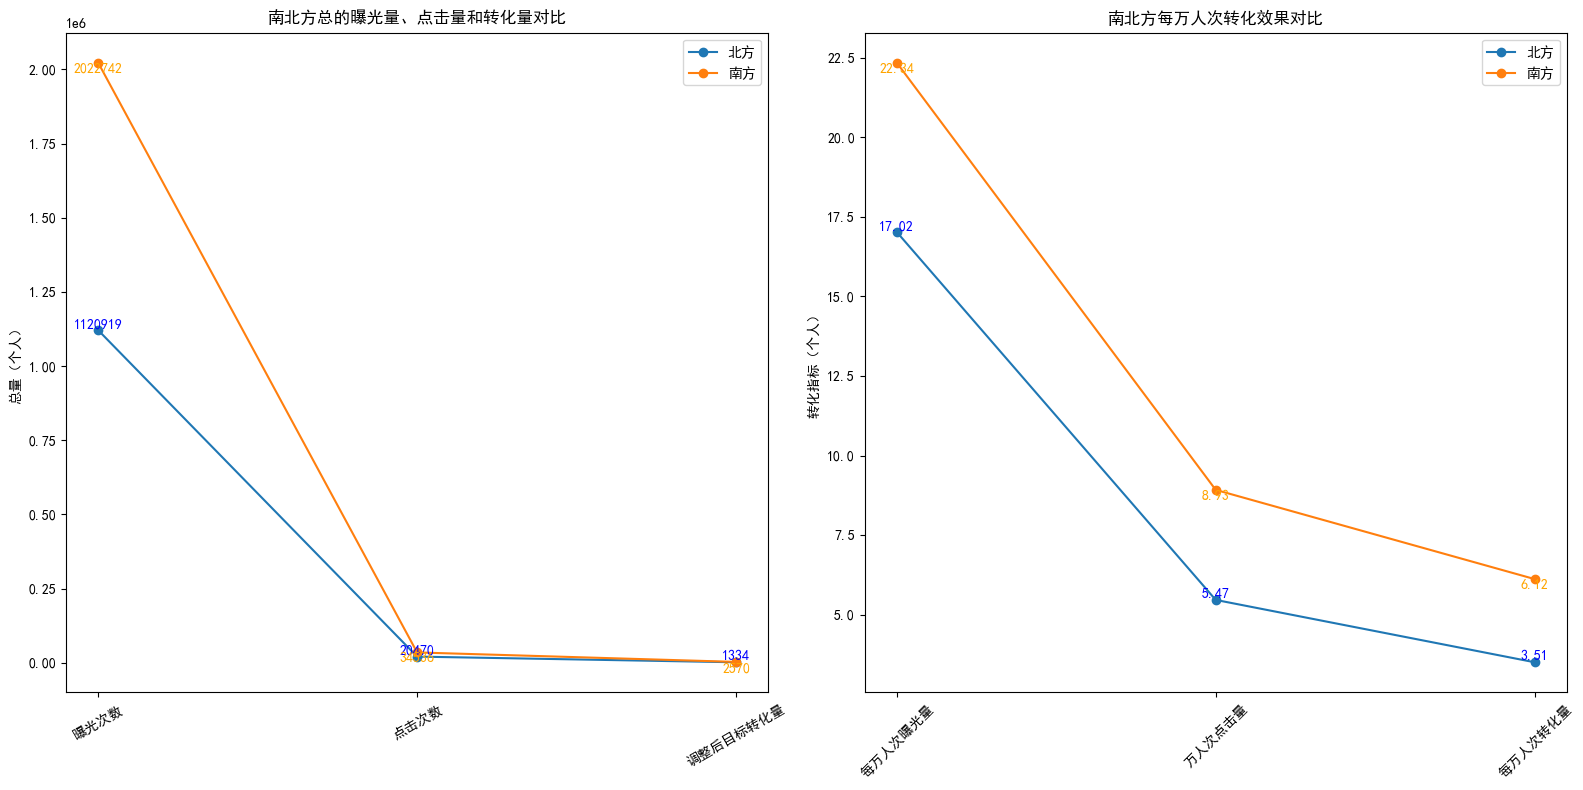

In [16]:
#转化效果分析
# 设置图表大小
plt.figure(figsize=(16, 8))

x_labels_1 = ['曝光次数', '点击次数', '调整后目标转化量']
north_values_1 = [
    compare_NS_df.loc['曝光次数', '北方总和'],
    compare_NS_df.loc['点击次数', '北方总和'],
    compare_NS_df.loc['调整后目标转化量', '北方总和']
]

south_values_1 = [
    compare_NS_df.loc['曝光次数', '南方总和'],
    compare_NS_df.loc['点击次数', '南方总和'],
    compare_NS_df.loc['调整后目标转化量', '南方总和']
]


x_labels_2 = ['每万人次曝光量','万人次点击量','每万人次转化量']
north_values_2 = [
    compare_NS_df.loc['每万人次曝光量', '北方总和'],
    compare_NS_df.loc['万人次点击量', '北方总和'],
    compare_NS_df.loc['每万人次转化量', '北方总和']
]
south_values_2 = [
    compare_NS_df.loc['每万人次曝光量', '南方总和'],
    compare_NS_df.loc['万人次点击量', '南方总和'],
    compare_NS_df.loc['每万人次转化量', '南方总和']
]

x1 = np.arange(len(x_labels_1))
x2 = np.arange(len(x_labels_2))

plt.subplot(1, 2, 1)
plt.plot(x1, north_values_1, marker='o', linestyle='-', label='北方')
plt.plot(x1, south_values_1, marker='o', linestyle='-', label='南方')

for i, yval in enumerate(north_values_1):
    plt.text(i, yval, round(yval, 2), ha='center', va='bottom', fontsize=10, color='blue', weight='bold')

for i, yval in enumerate(south_values_1):
    plt.text(i, yval, round(yval, 2), ha='center', va='top', fontsize=10, color='orange', weight='bold')

plt.ylabel('总量（个人）')
plt.title('南北方总的曝光量、点击量和转化量对比')
plt.xticks(x1, x_labels_1, rotation=30)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, north_values_2, marker='o', linestyle='-', label='北方')
plt.plot(x2, south_values_2, marker='o', linestyle='-', label='南方')

for i, yval in enumerate(north_values_2):
    plt.text(i, yval, round(yval, 2), ha='center', va='bottom', fontsize=10, color='blue', weight='bold')

for i, yval in enumerate(south_values_2):
    plt.text(i, yval, round(yval, 2), ha='center', va='top', fontsize=10, color='orange', weight='bold')

plt.ylabel('转化指标（个人）')
plt.title('南北方每万人次转化效果对比')
plt.xticks(x2, x_labels_2, rotation=45)
plt.legend()


plt.tight_layout()
plt.savefig("G:\桌面文件\data")
plt.show()

In [17]:
state_name = state['地域']

In [18]:
k_features = ['曝光次数','点击次数','花费','点击率','目标转化率','调整后目标转化量',
                '调整后目标转化成本','调整后下单ROI','每万次曝光产生的销售额'
]

scaler = StandardScaler()

need_scaler_data = state[k_features]

data_scaled = scaler.fit_transform(need_scaler_data)

kmeans = KMeans(n_clusters=4, random_state=0)
state['类别'] = kmeans.fit_predict(data_scaled)

display(state[['地域','类别']])

# 查看每个类别的特征均值
cluster_summary = state.groupby('类别')[k_features].mean()
display(cluster_summary)

G:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,地域,类别
0,北京市,3
1,天津市,3
2,河北省,1
3,山西省,3
4,内蒙古自治区,3
5,辽宁省,3
6,吉林省,3
7,黑龙江省,3
8,上海市,3
9,江苏省,1


,曝光次数,点击次数,花费,点击率,目标转化率,调整后目标转化量,调整后目标转化成本,调整后下单ROI,每万次曝光产生的销售额
类别,,,,,,,,,
0,441249.000000,7243.000000,21084.630000,1.640000,7.900000,572.000000,41.418781,0.423962,433.870445
1,137329.733333,2372.666667,6207.720667,1.721333,6.930000,164.466667,40.272729,0.765924,406.624820
2,97.333333,1.000000,2.840000,0.486667,0.000000,0.000000,0.382585,1.943937,0.000000
3,42811.600000,811.333333,2102.926667,1.843333,7.109333,57.666667,37.824168,0.939545,437.530415


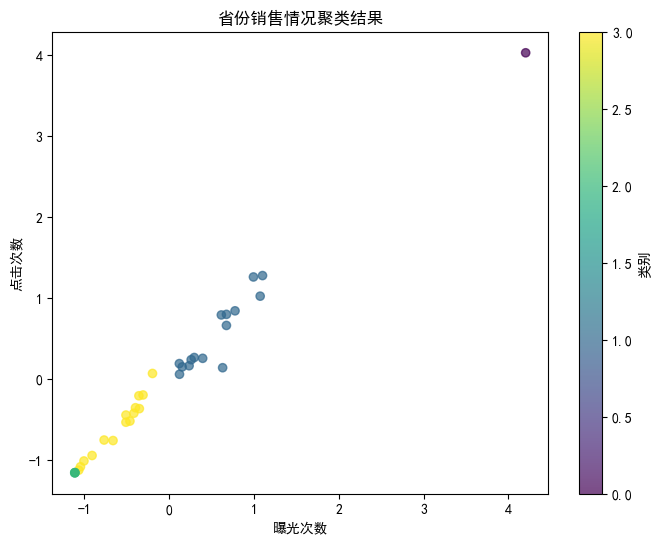

In [19]:
import matplotlib.pyplot as plt

# 绘制散点图
plt.figure(figsize=(8, 6))
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=state['类别'], cmap='viridis', alpha=0.7)
plt.title('省份销售情况聚类结果')
plt.xlabel(k_features[0])
plt.ylabel(k_features[1])
plt.colorbar(label='类别')
plt.savefig("G:\桌面文件\data\无监督4归类.jpg")
plt.show()

In [20]:
#t0 = 数据非常好的省份
#t1 = 具有良好数据的省份
#t2 = 建议停止投资的省份
#t3 = 具有潜力的省份

state_t0 = state[state['类别'] == 0]
state_t1 = state[state['类别'] == 1]
state_t2 = state[state['类别'] == 2]
state_t3 = state[state['类别'] == 3]

sorted_state = state.sort_values(by='类别', ascending= True)

display(state_t0)
print('*'*80)
display(state_t1)
print('*'*80)
display(state_t2)
print('*'*80)
display(state_t3)

,地域,曝光次数,点击次数,花费,下单金额,点击率,目标转化率,人口数量（万人）,人口占比,调整后目标转化量,调整后目标转化成本,调整后下单ROI,调整后点击均价,调整后下单单价,调整后下单ROI（点击归因）,每万人次曝光量,每万人次点击率,万人次点击量,每万人次转化量,每万人次下单金额,每万人次花费,点击均价,每次下单金额,每人次花费,每人次曝光量,每万次曝光花费,每万次点击花费,每万次转化花费,每万次曝光产生的销售额,每万次点击产生的销售额,每万次转化产生的销售额,南北方_南0_北1,类别
18,广东省,441249,7243,21084.63,19144.49,1.64,7.9,12601.3,0.087417,572,41.418781,0.423962,3.142528,38.680035,1.576038,35.016149,0.574782,20.126651,15.900054,1.519247,1.673211,2.911035,33.469388,0.000167,0.003502,477.839723,29110.354825,368612.412587,433.870445,26431.713378,334693.881119,0,0


********************************************************************************


,地域,曝光次数,点击次数,花费,下单金额,点击率,目标转化率,人口数量（万人）,人口占比,调整后目标转化量,调整后目标转化成本,调整后下单ROI,调整后点击均价,调整后下单单价,调整后下单ROI（点击归因）,每万人次曝光量,每万人次点击率,万人次点击量,每万人次转化量,每万人次下单金额,每万人次花费,点击均价,每次下单金额,每人次花费,每人次曝光量,每万次曝光花费,每万次点击花费,每万次转化花费,每万次曝光产生的销售额,每万次点击产生的销售额,每万次转化产生的销售额,南北方_南0_北1,类别
2,河北省,102355,1883,4595.58,4453.81,1.84,6.64,7461.0,0.051758,125,39.459171,0.635267,2.577676,38.714767,1.364733,13.718670,0.252379,3.462305,2.298970,0.596945,0.615947,2.440563,35.630480,0.000062,0.001372,448.984417,24405.629315,367646.400000,435.133604,23652.734997,356304.800000,1,1
9,江苏省,148425,2541,6978.38,6467.91,1.71,7.32,8474.8,0.058791,186,40.585934,0.623922,2.906383,38.273925,1.376078,17.513688,0.299830,5.251130,3.843827,0.763193,0.823427,2.746312,34.773710,0.000082,0.001751,470.162035,27463.124754,375181.720430,435.769581,25454.191263,347737.096774,0,1
10,浙江省,181465,3046,8651.70,8116.74,1.68,7.68,6456.8,0.044792,234,39.305881,0.719503,2.959146,37.359578,1.280497,28.104479,0.471751,13.258308,10.182381,1.257084,1.339936,2.840348,34.686923,0.000134,0.002810,476.769625,28403.479974,369730.769231,447.289560,26647.209455,346869.230769,0,1
11,安徽省,125184,1974,5185.35,4522.45,1.58,6.74,6102.7,0.042335,133,41.197778,0.804275,2.742611,36.523175,1.195725,20.512888,0.323463,6.635168,4.472103,0.741057,0.849681,2.626824,34.003383,0.000085,0.002051,414.218271,26268.237082,389875.939850,361.264219,22910.081054,340033.834586,0,1
12,福建省,113936,1950,5827.60,5365.49,1.71,8.21,4154.0,0.028817,160,37.922795,0.859082,3.066653,35.247480,1.140918,27.428021,0.469427,12.875455,10.570749,1.291644,1.402889,2.988513,33.534312,0.000140,0.002743,511.480129,29885.128205,364225.000000,470.921394,27515.333333,335343.125000,0,1
13,江西省,102511,1699,4522.95,4192.86,1.66,7.18,4518.9,0.031348,122,38.704805,0.833438,2.743386,36.238349,1.166562,22.684945,0.375976,8.529005,6.123826,0.927850,1.000896,2.662125,34.367705,0.000100,0.002268,441.216065,26621.247793,370733.606557,409.015618,24678.399058,343677.049180,0,1
14,山东省,174863,3377,7840.20,7539.83,1.93,6.49,10152.7,0.070430,219,39.472949,0.500070,2.507345,38.627656,1.499930,17.223300,0.332621,5.728829,3.718010,0.742643,0.772228,2.321646,34.428447,0.000077,0.001722,448.362432,23216.464317,358000.000000,431.184985,22327.006219,344284.474886,1,1
15,河南省,143443,2722,5518.46,4590.65,1.90,5.03,9936.6,0.068931,137,43.874770,0.641327,2.213357,37.618309,1.358673,14.435823,0.273937,3.954503,1.989115,0.461994,0.555367,2.027355,33.508394,0.000056,0.001444,384.714486,20273.548861,402807.299270,320.033044,16864.988979,335083.941606,1,1
16,湖北省,116936,1988,5287.22,4857.21,1.70,7.04,5775.3,0.040064,140,39.859334,0.775131,2.766570,37.077810,1.224869,20.247606,0.344225,6.969723,4.906685,0.841032,0.915488,2.659567,34.694357,0.000092,0.002025,452.146473,26595.674044,377658.571429,415.373367,24432.645875,346943.571429,0,1
17,湖南省,148452,2732,7362.98,6757.15,1.84,7.43,6644.5,0.046094,203,38.673785,0.730052,2.822609,36.037183,1.269948,22.342087,0.411167,9.186332,6.825445,1.016954,1.108132,2.695088,33.286453,0.000111,0.002234,495.983887,26950.878477,362708.374384,455.174063,24733.345534,332864.532020,0,1


********************************************************************************


,地域,曝光次数,点击次数,花费,下单金额,点击率,目标转化率,人口数量（万人）,人口占比,调整后目标转化量,调整后目标转化成本,调整后下单ROI,调整后点击均价,调整后下单单价,调整后下单ROI（点击归因）,每万人次曝光量,每万人次点击率,万人次点击量,每万人次转化量,每万人次下单金额,每万人次花费,点击均价,每次下单金额,每人次花费,每人次曝光量,每万次曝光花费,每万次点击花费,每万次转化花费,每万次曝光产生的销售额,每万次点击产生的销售额,每万次转化产生的销售额,南北方_南0_北1,类别
31,台湾省,22,0,0.21,0.0,0.00,0.0,2356.9,0.016350,0,0.852657,1.875053,0.043491,0.974465,0.124947,0.009334,0.000000,0.000000,0.0,0.0,0.000089,0.00,0.0,8.910009e-09,9.334295e-07,95.454545,0.0,0.0,0.0,0.0,0.0,1,2
32,香港特别行政区,206,3,6.93,0.0,1.46,0.0,747.4,0.005185,0,0.270387,1.960378,2.323792,0.309014,0.039622,0.275622,0.004014,0.001106,0.0,0.0,0.009272,2.31,0.0,9.272143e-07,2.756222e-05,336.407767,23100.0,0.0,0.0,0.0,0.0,1,2
33,澳门特别行政区,64,0,1.38,0.0,0.00,0.0,68.3,0.000474,0,0.024709,1.996379,0.001260,0.028239,0.003621,0.937042,0.000000,0.000000,0.0,0.0,0.020205,0.00,0.0,2.020498e-06,9.370425e-05,215.625000,0.0,0.0,0.0,0.0,0.0,1,2


********************************************************************************


,地域,曝光次数,点击次数,花费,下单金额,点击率,目标转化率,人口数量（万人）,人口占比,调整后目标转化量,调整后目标转化成本,调整后下单ROI,调整后点击均价,调整后下单单价,调整后下单ROI（点击归因）,每万人次曝光量,每万人次点击率,万人次点击量,每万人次转化量,每万人次下单金额,每万人次花费,点击均价,每次下单金额,每人次花费,每人次曝光量,每万次曝光花费,每万次点击花费,每万次转化花费,每万次曝光产生的销售额,每万次点击产生的销售额,每万次转化产生的销售额,南北方_南0_北1,类别
0,北京市,66829,1342,3451.73,3144.35,2.01,7.08,2189.3,0.015187,95,37.122025,0.973038,2.610399,34.005171,1.026962,30.525282,0.612981,18.711428,13.247691,1.436235,1.576636,2.572079,33.098421,0.000158,0.003053,516.501818,25720.789866,363340.000000,470.506816,23430.327869,330984.210526,1,3
1,天津市,28742,565,1416.31,1495.96,1.97,7.96,1386.6,0.009619,45,31.971631,0.870292,2.535587,33.813293,1.129708,20.728400,0.407472,8.446233,6.723201,1.078869,1.021427,2.506743,33.243556,0.000102,0.002073,492.766683,25067.433628,314735.555556,520.478742,26477.168142,332435.555556,1,3
3,山西省,59441,1122,2527.21,2190.30,1.89,6.42,3491.6,0.024222,72,36.363158,0.948198,2.314430,31.863610,1.051802,17.024000,0.321343,5.470537,3.512085,0.627306,0.723797,2.252415,30.420833,0.000072,0.001702,425.162766,22524.153298,351001.388889,368.483034,19521.390374,304208.333333,1,3
4,内蒙古自治区,50102,872,2297.64,2479.36,1.74,8.83,2404.9,0.016683,77,30.710022,0.793408,2.674377,33.194311,1.206592,20.833299,0.362593,7.554009,6.670190,1.030962,0.955399,2.634908,32.199481,0.000096,0.002083,458.592471,26349.082569,298394.805195,494.862481,28433.027523,321994.805195,1,3
5,辽宁省,76077,1713,4067.18,3644.54,2.25,6.19,4259.1,0.029546,106,39.910817,0.878110,2.448592,36.140934,1.121890,17.862224,0.402198,7.184145,4.446986,0.855707,0.954939,2.374302,34.382453,0.000095,0.001786,534.613615,23743.023935,383696.226415,479.059374,21275.773497,343824.528302,1,3
6,吉林省,50115,996,2633.49,2060.08,1.99,6.63,2407.3,0.016700,66,40.770891,1.090081,2.684421,32.205303,0.909919,20.817929,0.413742,8.613242,5.710579,0.855764,1.093960,2.644066,31.213333,0.000109,0.002082,525.489374,26440.662651,399013.636364,411.070538,20683.534137,312133.333333,1,3
7,黑龙江省,62784,1328,3335.19,2668.55,2.12,6.10,3185.0,0.022095,81,42.332240,1.031052,2.568772,34.266845,0.968948,19.712402,0.416954,8.219174,5.013696,0.837849,1.047155,2.511438,32.945062,0.000105,0.001971,531.216552,25114.382530,411751.851852,425.036634,20094.503012,329450.617284,1,3
8,上海市,57852,1027,2990.36,2425.72,1.78,6.82,2487.1,0.017253,70,43.619760,1.056950,2.955894,35.678297,0.943050,23.260826,0.412931,9.605110,6.550685,0.975321,1.202348,2.911743,34.653143,0.000120,0.002326,516.898292,29117.429406,427194.285714,419.297518,23619.474197,346531.428571,0,3
20,海南省,16973,298,940.80,819.50,1.76,8.05,1008.1,0.006993,24,39.564701,1.075457,3.178602,34.566801,0.924543,16.836623,0.295606,4.977000,4.006485,0.812915,0.933241,3.157047,34.145833,0.000093,0.001684,554.292111,31570.469799,392000.000000,482.825664,27500.000000,341458.333333,0,3
21,重庆市,63230,1106,3108.96,2778.85,1.75,7.96,3205.4,0.022236,88,36.489620,0.936271,2.869148,32.905280,1.063729,19.726087,0.345043,6.806343,5.417849,0.866928,0.969913,2.810995,31.577841,0.000097,0.001973,491.690653,28109.945750,353290.909091,439.482840,25125.226040,315778.409091,0,3


,调整后下单ROI,目标转化率,花费,每万次曝光产生的销售额
类别,,,,
0,0.423962,7.90,21084.63,433.870445
1,11.488857,103.95,93115.81,6099.372304
2,5.831810,0.00,8.52,0.000000
3,14.093172,106.64,31543.90,6562.956219


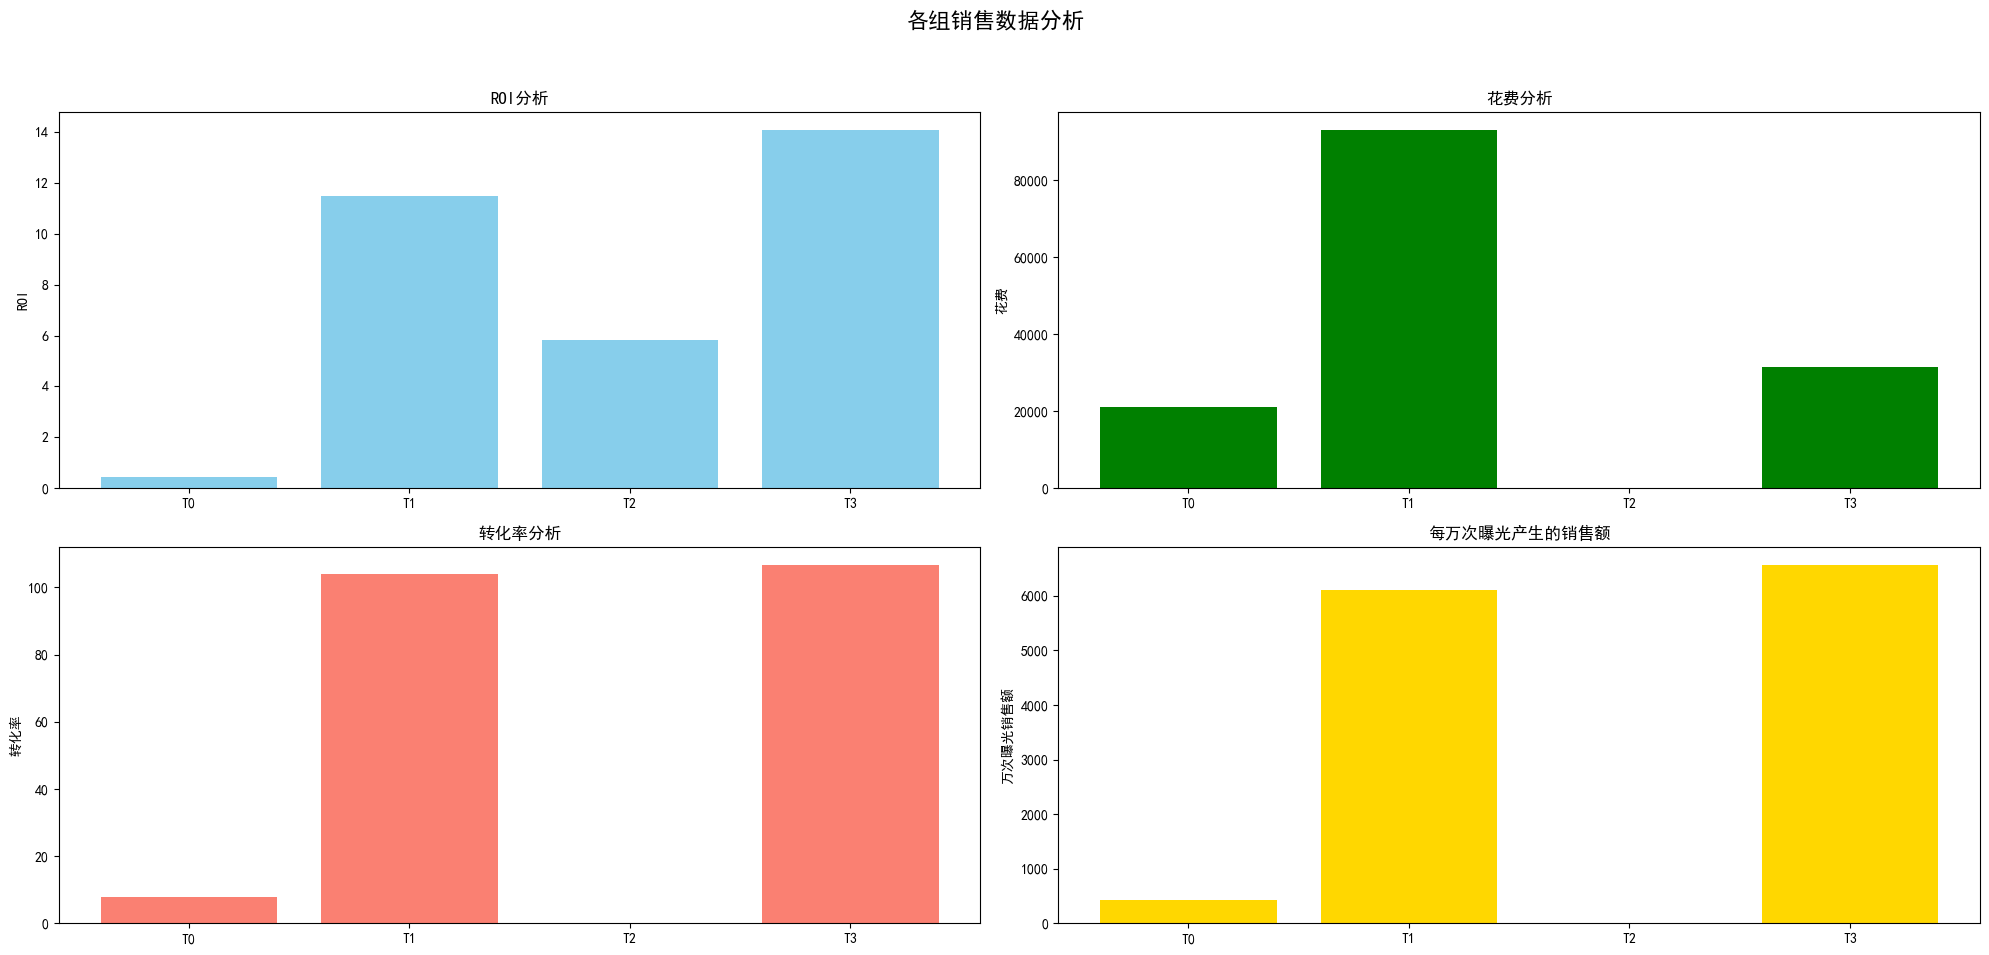

In [21]:
features_val = state.groupby('类别')[['调整后下单ROI','目标转化率','花费','每万次曝光产生的销售额']].sum()
display(features_val)

group_labels = ['T0','T1','T2','T3']

roi_val = features_val['调整后下单ROI']
convert_rate = features_val['目标转化率']
cost_val = features_val['花费']
renve_10k_exposure = features_val['每万次曝光产生的销售额']

fig, axes = plt.subplots(2,2,figsize=(20,10))
fig.suptitle('各组销售数据分析', fontsize = 16)

axes[0,0].bar(group_labels, roi_val, color = 'skyblue')
axes[0,0].set_title('ROI分析')
axes[0,0].set_ylabel('ROI')

axes[0,1].bar(group_labels, cost_val, color = 'green')
axes[0,1].set_title('花费分析')
axes[0,1].set_ylabel('花费')

axes[1,0].bar(group_labels, convert_rate, color = 'salmon')
axes[1,0].set_title('转化率分析')
axes[1,0].set_ylabel('转化率')

axes[1,1].bar(group_labels, renve_10k_exposure, color = 'gold')
axes[1,1].set_title('每万次曝光产生的销售额')
axes[1,1].set_ylabel('万次曝光销售额')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("G:\桌面文件\data\组分别情况.jpg")
plt.show()

In [22]:
#计算个组别权重
gpd_val= state.groupby('类别')[['下单金额']].sum()
gpd_val_roi= state.groupby('类别')[['调整后下单ROI']].median()

total_revenue = gpd_val['下单金额'].sum()

gpd_val['投资权重_销售额'] = gpd_val['下单金额']/ total_revenue
total_roi = gpd_val_roi['调整后下单ROI'].sum()
gpd_val['投资权重_ROI'] = gpd_val_roi['调整后下单ROI'] / total_roi

gpd_val['综合评分'] = gpd_val['下单金额'] * 0.5 + gpd_val_roi['调整后下单ROI'] * 0.5
total_score = gpd_val['综合评分'].sum()
gpd_val['投资权重_综合'] = gpd_val['综合评分'] / total_score

gpd_val['调整后下单ROI'] = gpd_val_roi['调整后下单ROI'].round(2)
gpd_val['投资权重_ROI'] =gpd_val['投资权重_ROI'].round(2)
gpd_val['投资权重_销售额'] = gpd_val['投资权重_销售额'].round(2)
gpd_val['投资权重_综合'] =gpd_val['投资权重_综合'].round(2)

In [23]:
#去除投资性价比低得组别
gpd_val = gpd_val.drop(index=2)

total_weight = gpd_val['投资权重_综合'].sum()
gpd_val['调整后投资权重'] = gpd_val['投资权重_综合']/ total_weight

display(gpd_val)

,下单金额,投资权重_销售额,投资权重_ROI,综合评分,投资权重_综合,调整后下单ROI,调整后投资权重
类别,,,,,,,
0,19144.49,0.15,0.10,9572.456981,0.15,0.42,0.15
1,84016.76,0.64,0.19,42008.767566,0.64,0.78,0.64
3,28220.74,0.21,0.24,14110.856519,0.21,0.97,0.21


In [24]:
#50万元新投资得情况下，预测回报率
total_invest = 500000

gpd_val['分配投资额'] = gpd_val['调整后投资权重'] * total_invest

gpd_val['预期回报'] = gpd_val['分配投资额'] * gpd_val_roi['调整后下单ROI']

total_payback = gpd_val['预期回报'].sum().round(2)

display(gpd_val[['分配投资额', '调整后投资权重','调整后下单ROI', '预期回报']])
print('-'*50)
print(f'50万元广告花费在默认投资比得回报是{total_payback}元')

,分配投资额,调整后投资权重,调整后下单ROI,预期回报
类别,,,,
0,75000.0,0.15,0.42,31797.121894
1,320000.0,0.64,0.78,248042.056977
3,105000.0,0.21,0.97,102168.953893


--------------------------------------------------
50万元广告花费在默认投资比得回报是382008.13元


In [25]:
#调配权重，限制+- 0.05区间，获得投资回报最大值权重
total_invest = 500000
init_w = np.array([0.15, 0.64, 0.21])
returns = gpd_val['调整后下单ROI'].values 

def objective(weights):
    allocated_investment = weights * total_invest
    expected_returns = allocated_investment * returns
    total_payback = expected_returns.sum()
    return -total_payback

constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

bounds = [(max(w - 0.05, 0), min(w + 0.05, 1)) for w in init_w]
result = minimize(objective, init_w, bounds=bounds, constraints=constraints)

best_w = result.x
best_return = -result.fun  

gpd_val['最佳分配投资额'] = best_w * total_invest
gpd_val['最佳预期回报'] = gpd_val['最佳分配投资额'] * gpd_val['调整后下单ROI']

print(f'最高回报值: {best_return:.2f}元')
print(f'最佳权重组合: {best_w}')
display(gpd_val[['最佳分配投资额', '最佳预期回报']])

最高回报值: 382950.00元
最佳权重组合: [0.15 0.64 0.21]


,最佳分配投资额,最佳预期回报
类别,,
0,75000.0,31500.0
1,320000.0,249600.0
3,105000.0,101850.0


In [26]:
#省份分析因1组数据量仅包括广东省，所以需要通过更细致 市数据进行进一步得分析

In [27]:
city.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   地域           404 non-null    object 
 1   曝光次数         404 non-null    object 
 2   点击次数         404 non-null    object 
 3   花费           404 non-null    object 
 4   目标转化量        404 non-null    int64  
 5   目标转化成本       404 non-null    float64
 6   下单金额         404 non-null    object 
 7   下单ROI        404 non-null    float64
 8   点击率          404 non-null    object 
 9   点击均价         404 non-null    float64
 10  目标转化率        404 non-null    object 
 11  下单单价         404 non-null    float64
 12  下单ROI（点击归因）  404 non-null    float64
dtypes: float64(5), int64(1), object(7)
memory usage: 41.2+ KB


In [28]:
# print(city['地域'].unique())

In [29]:
#拆分地域属于
city[['省份','城市']] = city['地域'].str.split('-', expand= True)
city = city.drop(['地域'], axis = 1)

In [30]:
population_dict = population_city.set_index('城市名称')['人口数量（万人）'].to_dict()

def fill_popu(city):
    if not isinstance(city, str):
        return None
    match, score = process.extractOne(city, population_dict.keys())
    print(f"Trying to match: {city} -> Best match: {match} with score: {score}") 
    if score >= 55:
        return population_dict[match]
    return None
city['人口数量(万人)'] = city['城市'].apply(fill_popu)

# print(city.head())

Trying to match: 北京市 -> Best match: 北京市 with score: 100
Trying to match: 天津市 -> Best match: 天津市 with score: 100
Trying to match: 石家庄市 -> Best match: 石家庄市 with score: 100
Trying to match: 唐山市 -> Best match: 唐山市 with score: 100
Trying to match: 秦皇岛市 -> Best match: 秦皇岛市 with score: 100
Trying to match: 邯郸市 -> Best match: 邯郸市 with score: 100
Trying to match: 邢台市 -> Best match: 邢台市 with score: 100
Trying to match: 保定市 -> Best match: 保定市 with score: 100
Trying to match: 张家口市 -> Best match: 张家口市 with score: 100
Trying to match: 承德市 -> Best match: 承德市 with score: 100
Trying to match: 沧州市 -> Best match: 沧州市 with score: 100
Trying to match: 廊坊市 -> Best match: 廊坊市 with score: 100
Trying to match: 衡水市 -> Best match: 衡水市 with score: 100
Trying to match: 河北省未知 -> Best match: 黑河市 with score: 45
Trying to match: 太原市 -> Best match: 太原市 with score: 100
Trying to match: 大同市 -> Best match: 大同市 with score: 100
Trying to match: 阳泉市 -> Best match: 阳泉市 with score: 100
Trying to match: 长治市 -> Best match: 长治市 w

In [31]:
#提取出所有包含 未知 的地区数据
unknow_data_city = city[city['城市'].str.contains('未知', na= False)]
# print(unknow_data_city)
#未知数据的综合值并没有太大的意义，所以选择drop

city = city[~city['城市'].str.contains('未知', na=False)]

#整体未知,和中国未知的数据量并不大，选择drop
city = city.drop([0,1])
city = city.reset_index(drop = True)
display(city.head())

,曝光次数,点击次数,花费,目标转化量,目标转化成本,下单金额,下单ROI,点击率,点击均价,目标转化率,下单单价,下单ROI（点击归因）,省份,城市,人口数量(万人)
0,"66,829","1,342","3,451.73",95,36.33,"3,144.35",0.9109,2.01%,2.57,7.08%,33.10,0.9109,北京市,北京市,2189.3
1,"28,742",565,"1,416.31",45,31.47,"1,495.96",1.0562,1.97%,2.51,7.96%,33.24,1.0562,天津市,天津市,1386.6
2,"14,853",248,673.88,9,74.88,290.55,0.4312,1.67%,2.72,3.63%,32.28,0.4312,河北省,石家庄市,1123.9
3,"9,643",170,475.52,19,25.03,694.34,1.4602,1.76%,2.80,11.18%,36.54,1.4602,河北省,唐山市,796.7
4,"3,829",55,187.81,3,62.60,89.4,0.4760,1.44%,3.41,5.45%,29.80,0.4760,河北省,秦皇岛市,312.7


In [32]:
#首先将省份进行label encode，然后计算出各省的城市人口均值，然后最后填充确实数据
label_encoder = LabelEncoder()

city['省份编码'] = label_encoder.fit_transform(city['省份'])

state_mean_popu = city.groupby('省份编码')['人口数量(万人)'].transform('mean')

city['人口数量(万人)'] = city['人口数量(万人)'].fillna(state_mean_popu)

display(city.isnull().sum().sort_values(ascending = False))
display(city.head())

人口数量(万人)       2
曝光次数           0
点击次数           0
花费             0
目标转化量          0
目标转化成本         0
下单金额           0
下单ROI          0
点击率            0
点击均价           0
目标转化率          0
下单单价           0
下单ROI（点击归因）    0
省份             0
城市             0
省份编码           0
dtype: int64

,曝光次数,点击次数,花费,目标转化量,目标转化成本,下单金额,下单ROI,点击率,点击均价,目标转化率,下单单价,下单ROI（点击归因）,省份,城市,人口数量(万人),省份编码
0,"66,829","1,342","3,451.73",95,36.33,"3,144.35",0.9109,2.01%,2.57,7.08%,33.10,0.9109,北京市,北京市,2189.3,3
1,"28,742",565,"1,416.31",45,31.47,"1,495.96",1.0562,1.97%,2.51,7.96%,33.24,1.0562,天津市,天津市,1386.6,7
2,"14,853",248,673.88,9,74.88,290.55,0.4312,1.67%,2.72,3.63%,32.28,0.4312,河北省,石家庄市,1123.9,17
3,"9,643",170,475.52,19,25.03,694.34,1.4602,1.76%,2.80,11.18%,36.54,1.4602,河北省,唐山市,796.7,17
4,"3,829",55,187.81,3,62.60,89.4,0.4760,1.44%,3.41,5.45%,29.80,0.4760,河北省,秦皇岛市,312.7,17


In [33]:
#手动fillna缺失人口数据
nan_rows = city[city['人口数量(万人)'].isnull()]

city.loc[371,'人口数量(万人)'] = 753.6
city.loc[372,'人口数量(万人)'] = 70.41

# print(city.info())

In [34]:
#转换数据格式obj to float
for col in city.select_dtypes(include=['object']).columns:
    if col not in ['省份','城市']:
        try:
            city[col] = city[col].str.replace(',', '').str.replace('%', '').astype(float)
        except ValueError:
            print(f'col{col}不能转换')

city.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   曝光次数         373 non-null    float64
 1   点击次数         373 non-null    float64
 2   花费           373 non-null    float64
 3   目标转化量        373 non-null    int64  
 4   目标转化成本       373 non-null    float64
 5   下单金额         373 non-null    float64
 6   下单ROI        373 non-null    float64
 7   点击率          373 non-null    float64
 8   点击均价         373 non-null    float64
 9   目标转化率        373 non-null    float64
 10  下单单价         373 non-null    float64
 11  下单ROI（点击归因）  373 non-null    float64
 12  省份           373 non-null    object 
 13  城市           373 non-null    object 
 14  人口数量(万人)     373 non-null    float64
 15  省份编码         373 non-null    int32  
dtypes: float64(12), int32(1), int64(1), object(2)
memory usage: 45.3+ KB


In [35]:
city.head()
#将比例数据减小100倍
city['点击率'] = city['点击率'] /100
city['目标转化率']=  city['目标转化率'] /100
pd.options.display.float_format = '{:.4f}'.format

print(city.describe())

            曝光次数      点击次数        花费    目标转化量   目标转化成本      下单金额    下单ROI  \
count   373.0000  373.0000  373.0000 373.0000 373.0000  373.0000 373.0000   
mean   8409.9223  147.1582  389.9466  10.4504  39.1871  351.6793   0.8964   
std   10106.5569  183.4571  498.9257  13.5347  27.0809  458.4182   0.6533   
min       1.0000    0.0000    0.0000   0.0000   0.0000    0.0000   0.0000   
25%    2660.0000   45.0000  121.7900   3.0000  25.8500   89.4000   0.5721   
50%    5809.0000   99.0000  256.1200   7.0000  36.1300  208.6000   0.8554   
75%   10017.0000  172.0000  449.8100  13.0000  48.1400  441.0400   1.1173   
max   67362.0000 1342.0000 3451.7300  95.0000 235.3900 3144.3500   7.1230   

           点击率     点击均价    目标转化率     下单单价  下单ROI（点击归因）  人口数量(万人)     省份编码  
count 373.0000 373.0000 373.0000 373.0000     373.0000  373.0000 373.0000  
mean    0.0171   2.6079   0.0670  30.5608       0.8964  416.2544  16.2011  
std     0.0053   0.7718   0.0380  11.1717       0.6533  367.3023   8.6139  
mi

In [36]:
city['每万人次曝光量'] = city['曝光次数'] / city['人口数量(万人)']
city['每万人次点击率'] = city['点击次数'] / city['人口数量(万人)']
city['万人次点击量'] = city['每万人次曝光量'] * city['每万人次点击率']
city['每万人次转化量'] = city['万人次点击量'] * (city['目标转化率'] / 10)
city['每万次曝光产生的销售额'] = (city['下单金额'] / city['曝光次数']) * 10000
city['点击均价'] = city['花费'] / city['点击次数']
city['每万次曝光花费'] = city['花费'] / (city['曝光次数'] / 10000)
city['每万次点击花费'] = city['花费'] / (city['点击次数'] / 10000)
city['每万次转化花费'] = city['花费'] / (city['目标转化量'] / 10000)
city['每次下单金额'] = city['下单金额'] / city['目标转化量']

state_total_sale = city.groupby('省份')['下单金额'].sum().rename('省内总销售')
nation_total_sale = state['下单金额'].sum()
city = city.merge(state_total_sale, on='省份')
city['省内销售占比%'] = city['下单金额'] / city['省内总销售']
city['国内销售占比%'] = city['下单金额'] / nation_total_sale

city.replace([np.inf, -np.inf], np.nan, inplace=True)

city['每次下单金额'] = city['每次下单金额'].fillna(city['每次下单金额'].median())
city['每万次点击花费'] = city['每万次点击花费'].fillna(city['每万次点击花费'].median())
city['每万次转化花费'] = city['每万次转化花费'].fillna(city['每万次转化花费'].median())
city['点击均价'] = city['点击均价'].fillna(city['点击均价'].median())

city = city.drop(['省内总销售'], axis = 1)

city['省内销售占比%'] = city['省内销售占比%'].fillna(0)
city.replace([np.inf, -np.inf], np.nan, inplace=True)

# display(city.head())

In [37]:
#对城市进行无监督归类以及异常数据检测
clustering_features = city[['曝光次数', '点击次数', '花费', '目标转化量', '目标转化成本', '下单金额', 
                 '下单ROI', '点击率', '目标转化率', '每万人次曝光量', '每万人次转化量', 
                 '每万次曝光产生的销售额', '省内销售占比%']]

imputer = SimpleImputer(strategy='mean')
clustering_features_imputed = imputer.fit_transform(clustering_features)

clustering_features_scaled = scaler.fit_transform(clustering_features)

#K-means 
kmeans_2rd = KMeans(n_clusters=6, random_state=42)
city['聚类标签'] = kmeans_2rd.fit_predict(clustering_features_scaled)

silhouette_avg = silhouette_score(clustering_features_scaled,city['聚类标签'])
# print(silhouette_avg)
# print('*'*100)

#isolation dect
isolation_forest = IsolationForest(contamination=0.05, random_state= 42)
city['异常标签'] = isolation_forest.fit_predict(clustering_features_scaled)

outliers = city[city['异常标签'] == 1]
# print("异常城市列表:\n", outliers[['城市', '省份', '曝光次数', '点击次数', '下单金额', '目标转化率']])

G:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


曝光次数前20城市：
        城市       曝光次数
199    广州市 67362.0000
0      北京市 66829.0000
253    重庆市 63230.0000
254    成都市 60084.0000
201    深圳市 59511.0000
72     上海市 57852.0000
215    东莞市 54448.0000
307    西安市 42045.0000
204    佛山市 40764.0000
220    南宁市 38461.0000
185    长沙市 35522.0000
168    武汉市 31646.0000
344  乌鲁木齐市 30581.0000
86     杭州市 30243.0000
77     苏州市 29789.0000
1      天津市 28742.0000
284    昆明市 27273.0000
209    惠州市 26395.0000
87     宁波市 26367.0000
88     温州市 26172.0000

转化率前20城市：
             城市  目标转化率
335     海南藏族自治州 0.3333
318        嘉峪关市 0.2000
343         中卫市 0.1724
256        攀枝花市 0.1714
326         庆阳市 0.1714
250     陵水黎族自治县 0.1667
243         定安县 0.1667
347         哈密市 0.1636
342         固原市 0.1538
34        锡林郭勒盟 0.1522
182         潜江市 0.1481
283  黔南布依族苗族自治州 0.1392
33          兴安盟 0.1351
28          通辽市 0.1333
29        鄂尔多斯市 0.1333
61          鸡西市 0.1299
237        五指山市 0.1250
184       神农架林区 0.1250
241         万宁市 0.1250
242         东方市 0.1250

ROI前20城市：
          城市  下单ROI
33

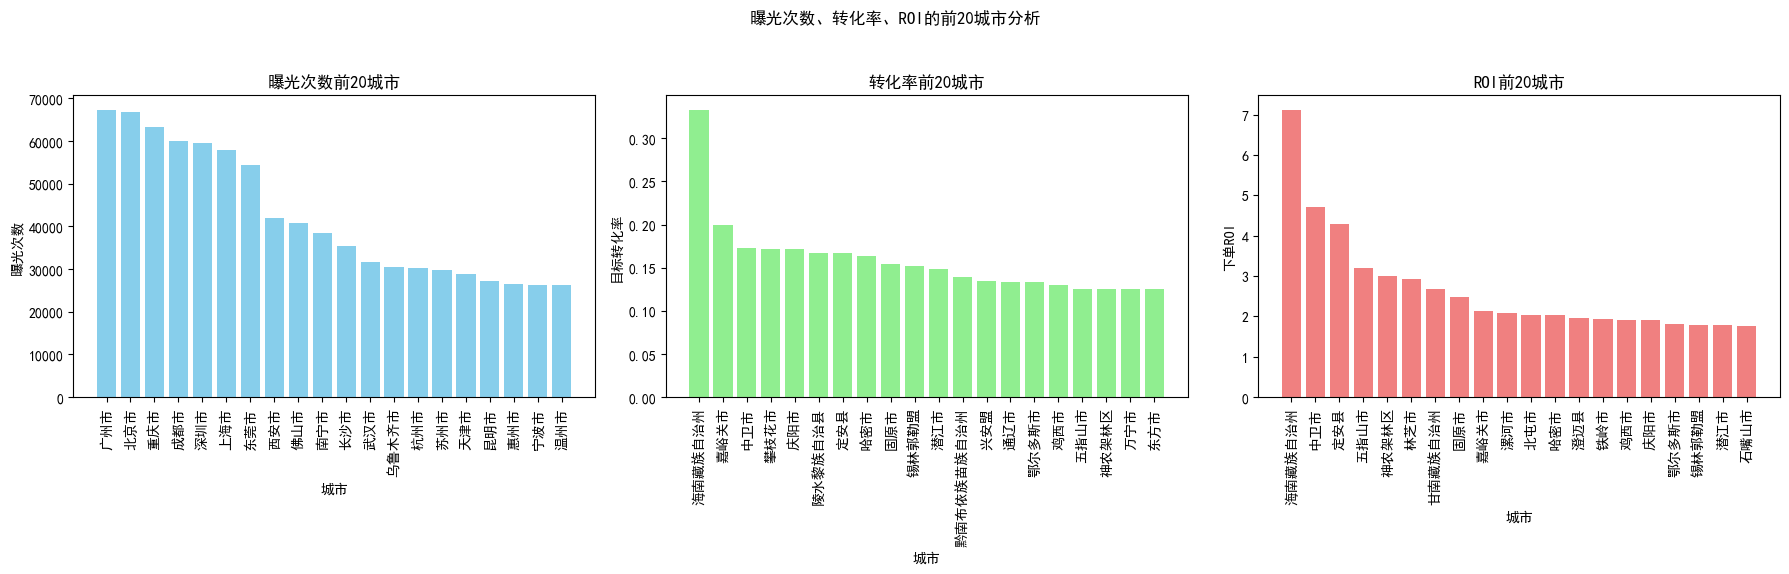

In [38]:
#对曝光最好，转化率最好，ROI的前20个城市进行排列
# 获取曝光、转化率和ROI的前20个城市并进行排序
top_20_exposure = city.sort_values('曝光次数', ascending=False).head(20)[['城市', '曝光次数']]
top_20_conversion_rate = city.sort_values('目标转化率', ascending=False).head(20)[['城市', '目标转化率']]
top_20_roi = city.sort_values('下单ROI', ascending=False).head(20)[['城市', '下单ROI']]

print("曝光次数前20城市：")
print(top_20_exposure)
print("\n转化率前20城市：")
print(top_20_conversion_rate)
print("\nROI前20城市：")
print(top_20_roi)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('曝光次数、转化率、ROI的前20城市分析')

axes[0].bar(top_20_exposure['城市'], top_20_exposure['曝光次数'], color='skyblue')
axes[0].set_title('曝光次数前20城市')
axes[0].set_xlabel('城市')
axes[0].set_ylabel('曝光次数')
axes[0].tick_params(axis='x', rotation=90)

axes[1].bar(top_20_conversion_rate['城市'], top_20_conversion_rate['目标转化率'], color='lightgreen')
axes[1].set_title('转化率前20城市')
axes[1].set_xlabel('城市')
axes[1].set_ylabel('目标转化率')
axes[1].tick_params(axis='x', rotation=90)

axes[2].bar(top_20_roi['城市'], top_20_roi['下单ROI'], color='lightcoral')
axes[2].set_title('ROI前20城市')
axes[2].set_xlabel('城市')
axes[2].set_ylabel('下单ROI')
axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

曝光次数末尾30城市：
            城市     曝光次数
369        基隆市   1.0000
368        桃园市   1.0000
367        台中市   1.0000
370        新北市   2.0000
236        三沙市   6.0000
372    澳门特别行政区   8.0000
371    香港特别行政区  13.0000
336    果洛藏族自治州  87.0000
305       阿里地区 124.0000
366        昆玉市 165.0000
237       五指山市 183.0000
337    玉树藏族自治州 188.0000
333    海北藏族自治州 191.0000
363       铁门关市 199.0000
184      神农架林区 208.0000
334    黄南藏族自治州 226.0000
244        屯昌县 241.0000
304        那曲市 248.0000
364        双河市 250.0000
303        山南市 259.0000
144        莱芜市 260.0000
335    海南藏族自治州 277.0000
251  保亭黎族苗族自治县 284.0000
252  琼中黎族苗族自治县 285.0000
247    白沙黎族自治县 298.0000
243        定安县 319.0000
246        临高县 391.0000
248    昌江黎族自治县 407.0000
301       日喀则市 412.0000
362        北屯市 434.0000

转化率末尾30城市：
              城市  目标转化率
372      澳门特别行政区 0.0000
305         阿里地区 0.0000
236          三沙市 0.0000
251    保亭黎族苗族自治县 0.0000
319          金昌市 0.0000
320          白银市 0.0000
249      乐东黎族自治县 0.0000
248      昌江黎族自治县 0.0000
360        图木舒克市

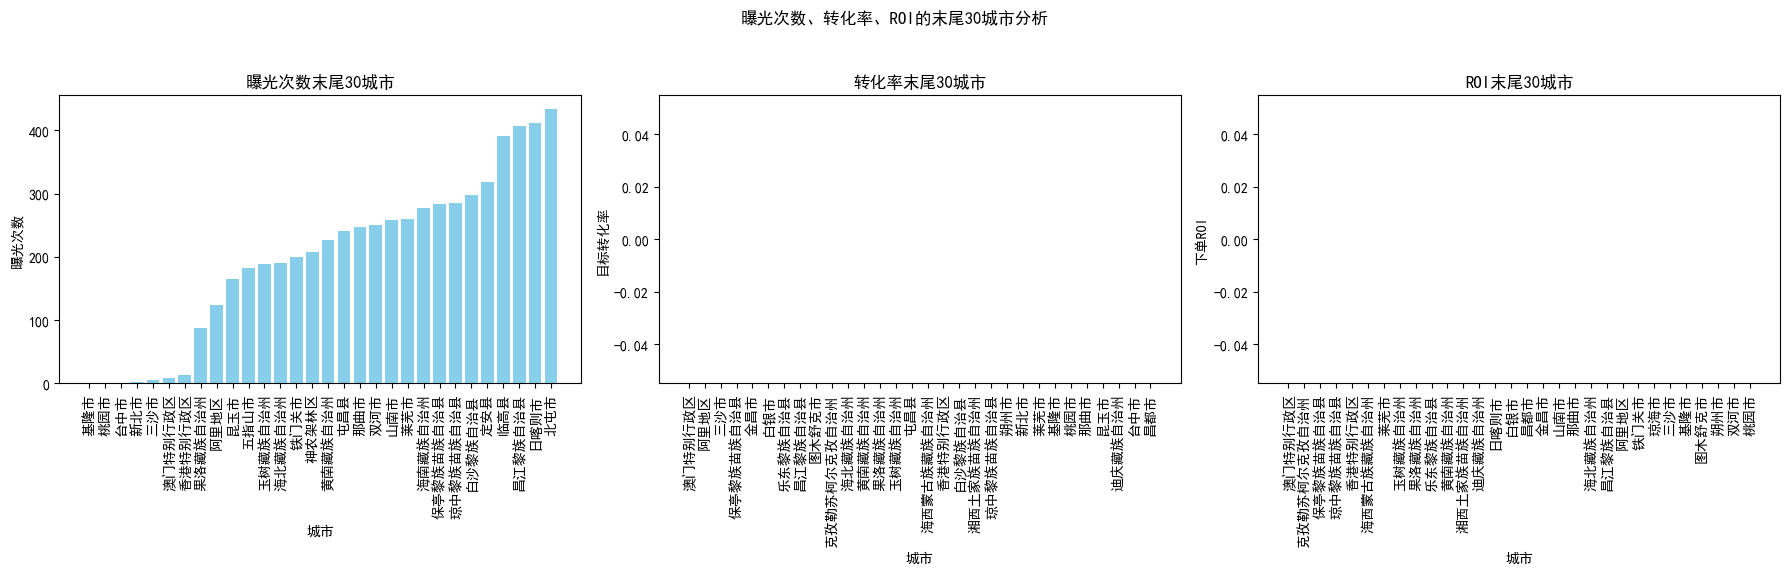

In [39]:
#对表现较差的城市进行末尾20名排序
# Assuming 'city' DataFrame is loaded with the necessary columns

# 获取曝光、转化率和ROI的末尾20个城市并进行排序
bottom_30_exposure = city.sort_values('曝光次数', ascending=True).head(30)[['城市', '曝光次数']]
bottom_30_conversion_rate = city.sort_values('目标转化率', ascending=True).head(30)[['城市', '目标转化率']]
bottom_30_roi = city.sort_values('下单ROI', ascending=True).head(30)[['城市', '下单ROI']]

# 打印末尾30个城市列表
print("曝光次数末尾30城市：")
print(bottom_30_exposure)
print("\n转化率末尾30城市：")
print(bottom_30_conversion_rate)
print("\nROI末尾30城市：")
print(bottom_30_roi)

# 可视化分析：创建柱状图
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('曝光次数、转化率、ROI的末尾30城市分析')

# 曝光次数柱状图
axes[0].bar(bottom_30_exposure['城市'], bottom_30_exposure['曝光次数'], color='skyblue')
axes[0].set_title('曝光次数末尾30城市')
axes[0].set_xlabel('城市')
axes[0].set_ylabel('曝光次数')
axes[0].tick_params(axis='x', rotation=90)

# 转化率柱状图
axes[1].bar(bottom_30_conversion_rate['城市'], bottom_30_conversion_rate['目标转化率'], color='lightgreen')
axes[1].set_title('转化率末尾30城市')
axes[1].set_xlabel('城市')
axes[1].set_ylabel('目标转化率')
axes[1].tick_params(axis='x', rotation=90)

# ROI柱状图
axes[2].bar(bottom_30_roi['城市'], bottom_30_roi['下单ROI'], color='lightcoral')
axes[2].set_title('ROI末尾30城市')
axes[2].set_xlabel('城市')
axes[2].set_ylabel('下单ROI')
axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

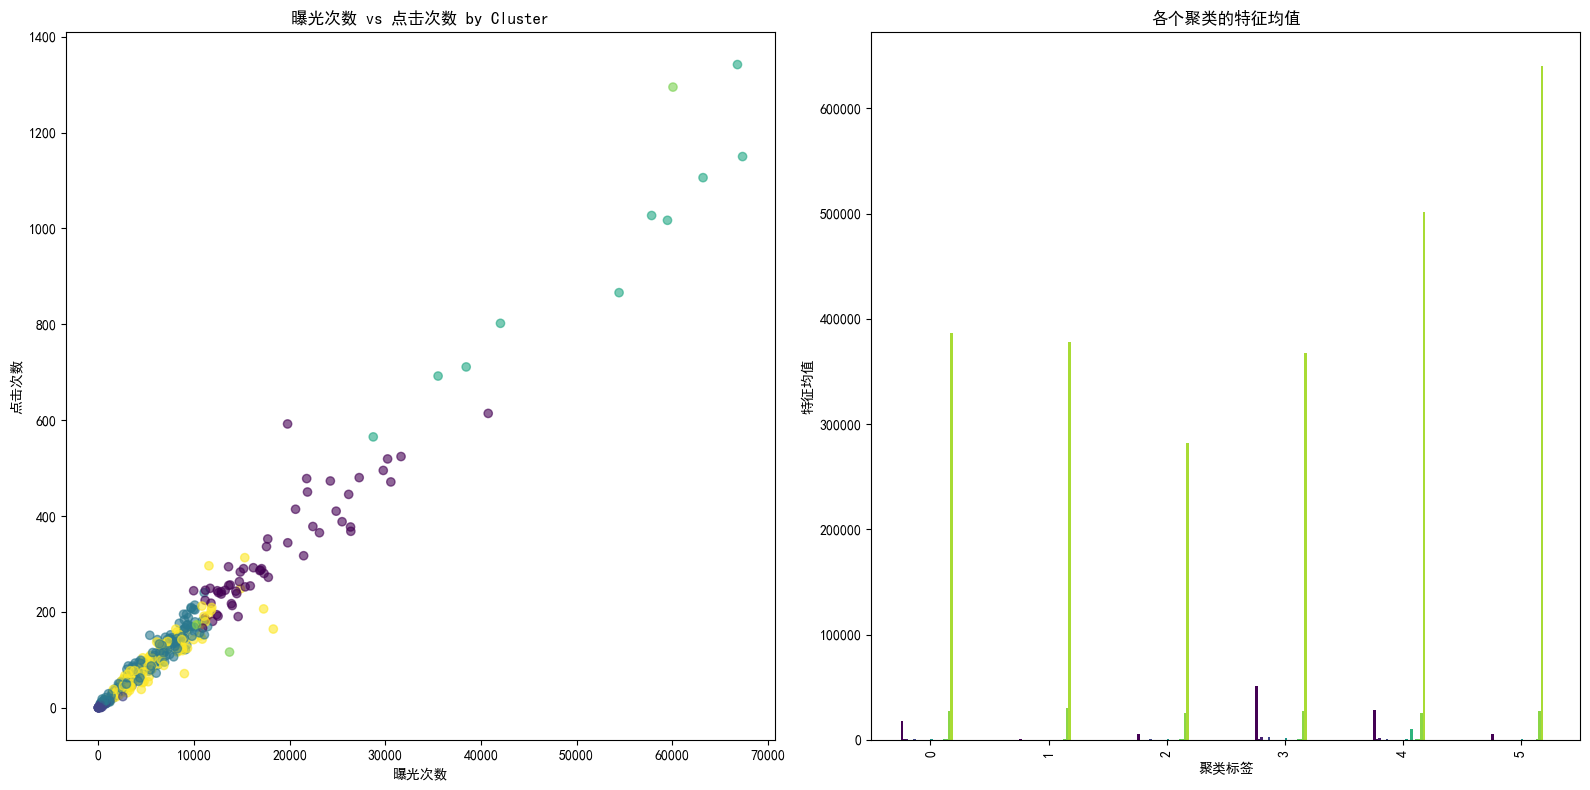

In [40]:
numeric_cols = city.select_dtypes(include=['float64', 'int64']).columns
cluster_means = city.groupby('聚类标签')[numeric_cols].mean()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

x_feature = '曝光次数'
y_feature = '点击次数'
ax1.scatter(city[x_feature], city[y_feature], c=city['聚类标签'], cmap='viridis', alpha=0.6)
ax1.set_title(f'{x_feature} vs {y_feature} by Cluster')
ax1.set_xlabel(x_feature)
ax1.set_ylabel(y_feature)

cluster_means.plot(kind='bar', ax=ax2, colormap='viridis', legend=False)
ax2.set_title("各个聚类的特征均值")
ax2.set_xlabel("聚类标签")
ax2.set_ylabel("特征均值")

plt.tight_layout()
plt.show()

In [41]:
#展示转化率为0或ROI为0的城市名称和所在省份
zero_data = city[(city['目标转化率'] == 0) | (city['下单ROI'] == 0)]
res = zero_data[['城市','省份','下单ROI','目标转化率','曝光次数','花费']]

print(res['花费'].sum())
print('**'*30)
display(res)

722.7499999999999
************************************************************


,城市,省份,下单ROI,目标转化率,曝光次数,花费
18,朔州市,山西省,0.0000,0.0000,1776.0000,62.1700
144,莱芜市,山东省,0.0000,0.0000,260.0000,8.2600
198,湘西土家族苗族自治州,湖南省,0.0000,0.0000,3510.0000,160.0400
236,三沙市,海南省,0.0000,0.0000,6.0000,0.2100
238,琼海市,海南省,0.0000,0.0000,807.0000,39.5000
244,屯昌县,海南省,0.0000,0.0000,241.0000,10.2900
247,白沙黎族自治县,海南省,0.0000,0.0000,298.0000,15.1200
248,昌江黎族自治县,海南省,0.0000,0.0000,407.0000,18.7400
249,乐东黎族自治县,海南省,0.0000,0.0000,626.0000,35.0500
251,保亭黎族苗族自治县,海南省,0.0000,0.0000,284.0000,15.0100


In [42]:
city_clu_t0= city[city['聚类标签'] == 0]
city_clu_t1= city[city['聚类标签'] == 1]
city_clu_t2= city[city['聚类标签'] == 2]
city_clu_t3= city[city['聚类标签'] == 3]
city_clu_t4= city[city['聚类标签'] == 4]
city_clu_t5= city[city['聚类标签'] == 5]

print(f"T0组: {city_clu_t0['城市']}")
print('--'*30)
print(f"T1组: {city_clu_t1['城市']}")
print('--'*30)
print(f"T2组: {city_clu_t2['城市']}")
print('--'*30)
print(f"T3组: {city_clu_t3['城市']}")
print('--'*30)
print(f"T4组: {city_clu_t4['城市']}")
print('--'*30)
print(f"T5组: {city_clu_t5['城市']}")

T0组: 7        保定市
11       廊坊市
13       太原市
36       沈阳市
37       大连市
50       长春市
51       吉林市
59      哈尔滨市
73       南京市
74       无锡市
76       常州市
77       苏州市
78       南通市
86       杭州市
87       宁波市
88       温州市
89       嘉兴市
91       绍兴市
92       金华市
95       台州市
97       合肥市
113      福州市
114      厦门市
117      泉州市
118      漳州市
122      南昌市
128      赣州市
132      上饶市
133      济南市
134      青岛市
138      烟台市
139      潍坊市
150      郑州市
152      洛阳市
162      南阳市
168      武汉市
176      荆州市
190      岳阳市
191      常德市
203      汕头市
204      佛山市
205      江门市
206      湛江市
207      茂名市
208      肇庆市
209      惠州市
214      清远市
216      中山市
221      柳州市
222      桂林市
228      玉林市
259      绵阳市
275      贵阳市
277      遵义市
284      昆明市
310      咸阳市
344    乌鲁木齐市
Name: 城市, dtype: object
------------------------------------------------------------
T1组: 18             朔州市
144            莱芜市
198     湘西土家族苗族自治州
236            三沙市
238            琼海市
244            屯昌县
247        白沙黎族自治县
248        昌江黎族自治县
249        乐

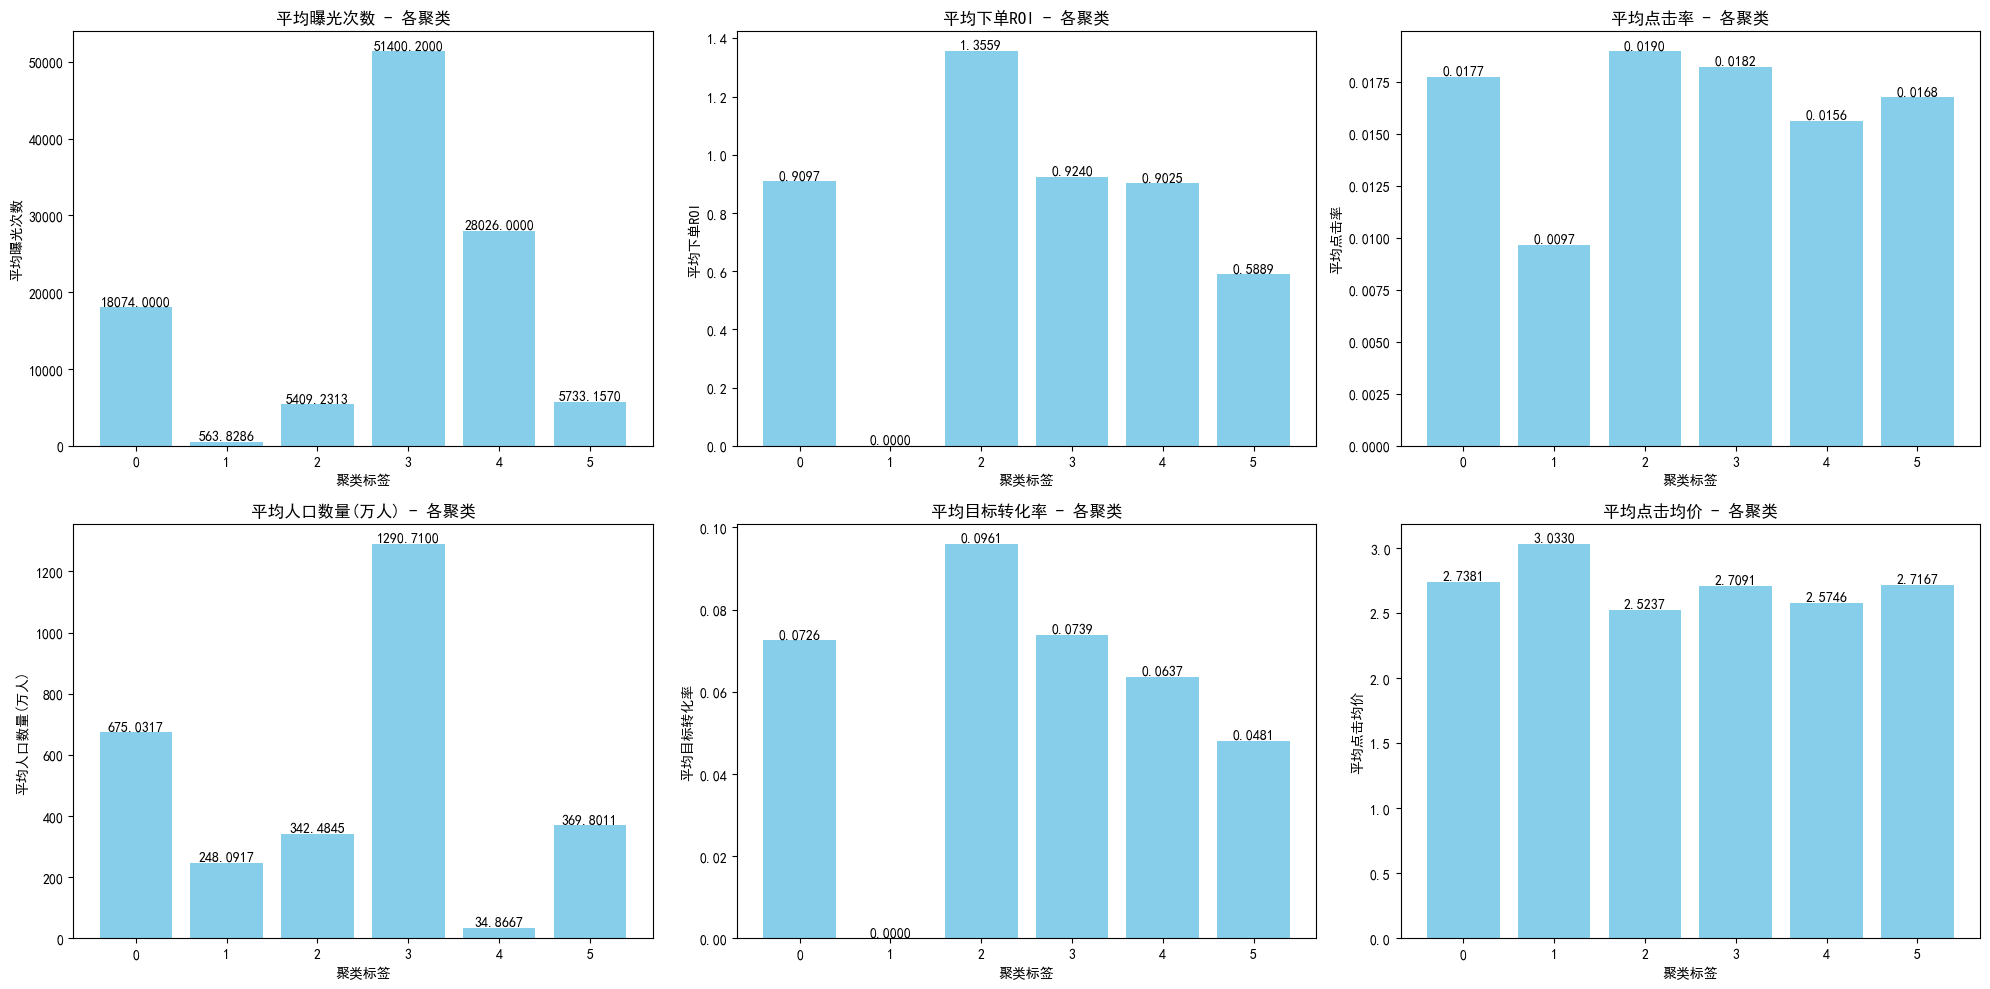

In [43]:
metrix = ['曝光次数', '下单ROI', '点击率', '人口数量(万人)', '目标转化率', '点击均价']

cluster_means =city.groupby('聚类标签')[metrix].mean()

fig,axes = plt.subplots(2,3,figsize = (20,10))
axes = axes.flatten()

for i, metric in enumerate(metrix):
    axes[i].bar(cluster_means.index, cluster_means[metric], color='skyblue')
    axes[i].set_title(f'平均{metric} - 各聚类')
    axes[i].set_xlabel('聚类标签')
    axes[i].set_ylabel(f'平均{metric}')

    for idx, value in enumerate(cluster_means[metric]):
        axes[i].text(idx, value, f'{value:.4f}', ha='center',va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

#根据数据显示，t1组大部分属于偏远山区具有较低的转化率以及平均点击单价，转化可能性较低，建议后期从投资列表中剔除
#t4组归类数据展示量太少也可以选择进行drop

每个聚类中异常数据的数量：
聚类标签
0     2
2     4
3    10
4     3
dtype: int64

每个聚类中异常数据的比例：
聚类标签
0     3.5088
1        NaN
2     2.7211
3   100.0000
4   100.0000
5        NaN
dtype: float64

异常数据的均值：
           曝光次数    点击率  下单ROI
聚类标签                         
0    33579.5000 0.0145 1.0348
2      457.0000 0.0326 4.8281
3    51400.2000 0.0182 0.9240
4    28026.0000 0.0156 0.9025

正常数据的均值：
           曝光次数    点击率  下单ROI
聚类标签                         
0    17510.1636 0.0179 0.9052
1      563.8286 0.0097 0.0000
2     5547.7552 0.0186 1.2588
5     5733.1570 0.0168 0.5889


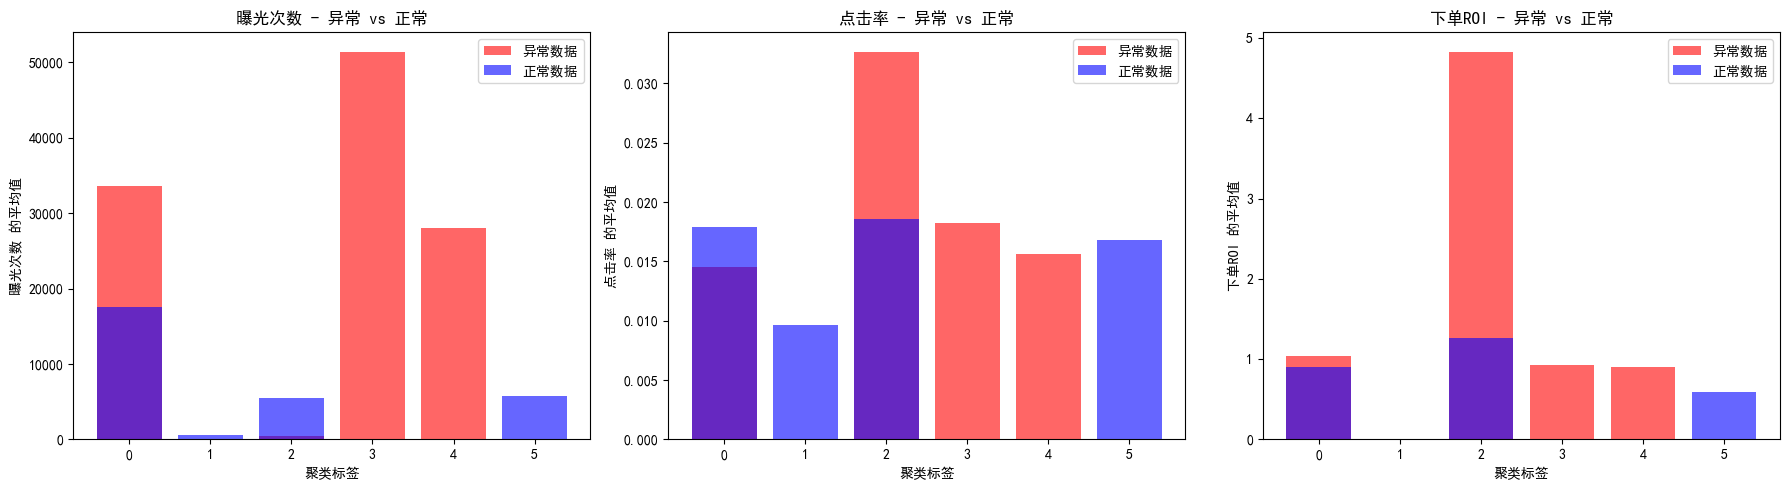

In [44]:
#异常数据检测
neg1_dect = city[city['异常标签'] == -1][['城市', '聚类标签']]
# print(neg1_dect)

# 1. 统计每个聚类中的异常数据数量
cluster_abnormal_counts = city[city['异常标签'] == -1].groupby('聚类标签').size()
print("每个聚类中异常数据的数量：")
print(cluster_abnormal_counts)

# 2. 计算每个聚类中异常数据占比
cluster_total_counts = city.groupby('聚类标签').size()
abnormal_ratio = cluster_abnormal_counts / cluster_total_counts * 100
print("\n每个聚类中异常数据的比例：")
print(abnormal_ratio)

# 3. 比较异常与正常数据在关键指标上的均值差异
# 关键指标
metrics = ['曝光次数', '点击率', '下单ROI']
abnormal_metrics_mean = city[city['异常标签'] == -1].groupby('聚类标签')[metrics].mean()
normal_metrics_mean = city[city['异常标签'] != -1].groupby('聚类标签')[metrics].mean()

print("\n异常数据的均值：")
print(abnormal_metrics_mean)
print("\n正常数据的均值：")
print(normal_metrics_mean)

# 4. 绘制异常数据和正常数据在关键指标上的对比

fig, axes = plt.subplots(1, len(metrics), figsize=(18, 5))
for i, metric in enumerate(metrics):
    axes[i].bar(abnormal_metrics_mean.index, abnormal_metrics_mean[metric], label='异常数据', alpha=0.6, color='red')
    axes[i].bar(normal_metrics_mean.index, normal_metrics_mean[metric], label='正常数据', alpha=0.6, color='blue')
    axes[i].set_title(f"{metric} - 异常 vs 正常")
    axes[i].set_xlabel('聚类标签')
    axes[i].set_ylabel(f'{metric} 的平均值')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [122]:
#构建神经无监督神经网络 对整体的features进行权重的获取
X = city.drop(['城市','省份','聚类标签','异常标签'], axis =1)
X_scaled = scaler.fit_transform(X)

encoding_dim = 6

input_dim = X_scaled.shape[1]
input_layer = Input(shape=(input_dim,))

# 手动创建编码器和解码器的各层
encoded = Dense(20, activation='relu')(input_layer)
encoded = Dense(10, activation='relu')(encoded)
encoded_output = Dense(encoding_dim, activation='relu', name='encoder')(encoded)

decoded = Dense(10, activation='relu')(encoded_output)
decoded = Dense(input_dim, activation='linear')(decoded)

# 构建自动编码器
autoencoder = Model(inputs=input_layer, outputs=decoded)

# 编译和训练模型
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_scaled, X_scaled, epochs=600, batch_size=32, shuffle=True, validation_split=0.2)

# 构建编码器模型，只包含编码器部分的层
encoder = Model(inputs=input_layer, outputs=encoded_output)

# 使用编码器提取低维特征表示
encoded_X = encoder.predict(X_scaled)

print("编码层输出（低维特征表示）：")
print(encoded_X)

Epoch 1/600
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.8364 - val_loss: 1.6431
Epoch 2/600
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7316 - val_loss: 1.6472
Epoch 3/600
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8574 - val_loss: 1.6475
Epoch 4/600
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7254 - val_loss: 1.6439
Epoch 5/600
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9903 - val_loss: 1.6331
Epoch 6/600
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7539 - val_loss: 1.6158
Epoch 7/600
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8001 - val_loss: 1.5928
Epoch 8/600
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8640 - val_loss: 1.5725
Epoch 9/600
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9395 - val_loss: 1.5545
Epoch 10/600
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9491 - val_loss: 1.5372
Epoch 11/600
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7502 - val_loss: 1.5173
Epoch 12/600
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

In [123]:
#解码器
encoded_input = Input(shape = (encoding_dim,))

decoder_layer_1 = autoencoder.layers[-2](encoded_input)
decoder_output = autoencoder.layers[-1](decoder_layer_1)

decoder = Model(inputs = encoded_input, outputs = decoder_output)

decoded_X = decoder.predict(encoded_X)

print("解码后的数据（接近原始输入）：")
print(decoded_X.shape)
print(decoded_X)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
解码后的数据（接近原始输入）：
(373, 25)
[[ 6.3551936   6.225498    6.4369884  ...  0.16907343  4.8214827
   6.349239  ]
 [ 2.8434918   3.0422876   2.9220128  ... -0.17125477  2.6967638
   2.9908075 ]
 [ 0.55683905  0.54310834  0.5424857  ... -0.24844548  0.03791095
   0.26436478]
 ...
 [ 0.13987188  0.03913204  0.05831068 ...  1.6902136  -0.3387697
   0.07685761]
 [-0.51798385 -0.45969093 -0.4890979  ... -0.4127472  -0.45732793
  -0.55991226]
 [-0.5279158  -0.46742535 -0.5701216  ...  0.6863265  -0.6224731
  -0.6007667 ]]


In [124]:
#评估神经网络模型
X_recon = autoencoder.predict(X_scaled)

recon_errors = np.mean(np.square(X_scaled - X_recon), axis =1)

# 打印重构误差的统计信息
print("平均重构误差:", np.mean(recon_errors))
print("中位重构误差:", np.median(recon_errors))
print("最大重构误差:", np.max(recon_errors))

#最大重构误差较大，检查较大误差数据样本

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
平均重构误差: 0.1597256210030836
中位重构误差: 0.03473329111759352
最大重构误差: 8.728171662396756


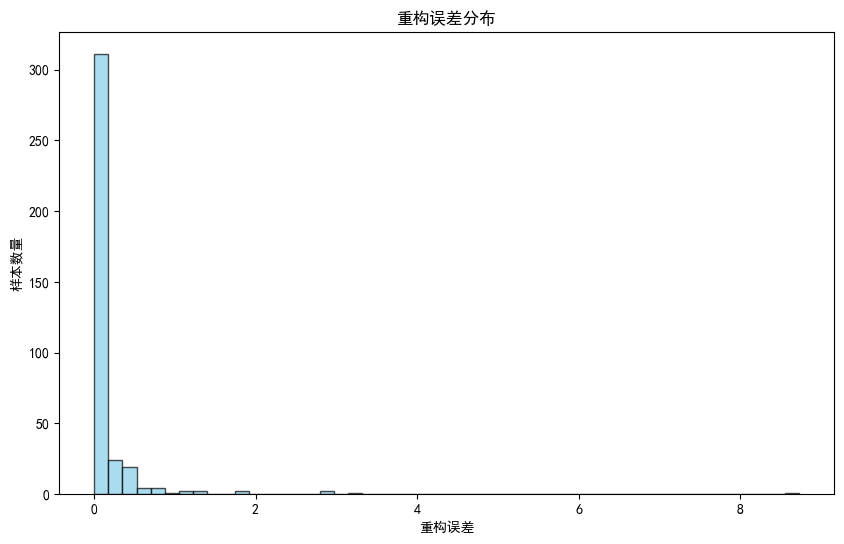

In [125]:
plt.figure(figsize=(10, 6))
plt.hist(recon_errors, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel("重构误差")
plt.ylabel("样本数量")
plt.title("重构误差分布")
plt.show()

#可视化误差分布

In [126]:
# 设置异常阈值
threshold = np.mean(recon_errors) + 3 * np.std(recon_errors)

# 找出所有重构误差超过阈值的样本索引
anomalies = np.where(recon_errors > threshold)[0]

print("异常样本数:", len(anomalies))
print("异常样本索引:", anomalies)

anomalies_data = city.iloc[anomalies]

# 查看异常样本的详细信息
print(anomalies_data)

#异常数据集中于一些数据偏差较大的城市，所以无关紧要，可以ignore

异常样本数: 4
异常样本索引: [335 348 351 357]
          曝光次数     点击次数       花费  目标转化量   目标转化成本     下单金额  下单ROI    点击率  \
335   277.0000   6.0000   8.3700      2   4.1800  59.6000 7.1230 0.0217   
348 10281.0000 173.0000 383.4200     16  23.9600 542.4400 1.4148 0.0168   
351 13713.0000 116.0000 351.7400      4  87.9300 143.0400 0.4067 0.0085   
357  3445.0000  43.0000 130.2300      1 130.2300  29.8000 0.2288 0.0125   

      点击均价  目标转化率    下单单价  下单ROI（点击归因）        省份       城市  人口数量(万人)  省份编码  \
335 1.3950 0.3333 29.8000       7.1230       青海省  海南藏族自治州   39.1000    31   
348 2.2163 0.0925 33.9000       1.4148  新疆维吾尔自治区  昌吉回族自治州   16.2000    14   
351 3.0322 0.0345 35.7600       0.4067  新疆维吾尔自治区    阿克苏地区   12.3000    14   
357 3.0286 0.0233 29.8000       0.2288  新疆维吾尔自治区    阿勒泰地区   12.3000    14   

      每万人次曝光量  每万人次点击率     万人次点击量  每万人次转化量  每万次曝光产生的销售额  每万次曝光花费    每万次点击花费  \
335    7.0844   0.1535     1.0871   0.0362    2151.6245 302.1661 13950.0000   
348  634.6296  10.6790  6777.2176  62.6893   

In [147]:
#构建决策树stacking模型 来预测城市所处等级 以及是否投资状态
param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [3, 5, 10, None],
    'gb__n_estimators': [50, 100, 200],
    'gb__learning_rate': [0.01, 0.05, 0.1],
    'dt__max_depth': [3, 5, 10, None],
    'xgb__n_estimators': [50, 100, 200],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'final_estimator__C': [0.1, 1, 10, 100]  
}

investment_labels = pd.cut(
    np.mean(np.abs(decoded_X - X_scaled), axis=1),
    bins = [-np.inf, 0.1, 0.2, np.inf],
    labels = ['不建议投资','具有潜力','值得投资']
)

X_train, X_test, y_train, y_test = train_test_split(encoded_X, investment_labels, test_size=0.1, random_state=42)

base_estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric = 'mlogloss', random_state=42))
]

stacking_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(),
    cv=5
)

random_search = RandomizedSearchCV(
    estimator=stacking_model,
    param_distributions= param_grid,
    n_iter= 50,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print(f'best params{random_search.best_params_}')
print(f'best score:{random_search.best_score_}')


y_pred = random_search.best_estimator_.predict(X_test)

print(classification_report(y_test, y_pred))

best params{'xgb__n_estimators': 50, 'xgb__learning_rate': 0.05, 'rf__n_estimators': 200, 'rf__max_depth': 10, 'gb__n_estimators': 50, 'gb__learning_rate': 0.05, 'final_estimator__C': 1, 'dt__max_depth': None}
best score:0.5194029850746269
              precision    recall  f1-score   support

       不建议投资       0.64      0.54      0.58        13
        值得投资       1.00      0.78      0.88         9
        具有潜力       0.65      0.81      0.72        16

    accuracy                           0.71        38
   macro avg       0.76      0.71      0.73        38
weighted avg       0.73      0.71      0.71        38



In [151]:
#保存最佳模型
joblib.dump(stacking_model,'best_stacking_model.pkl')

['best_stacking_model.pkl']

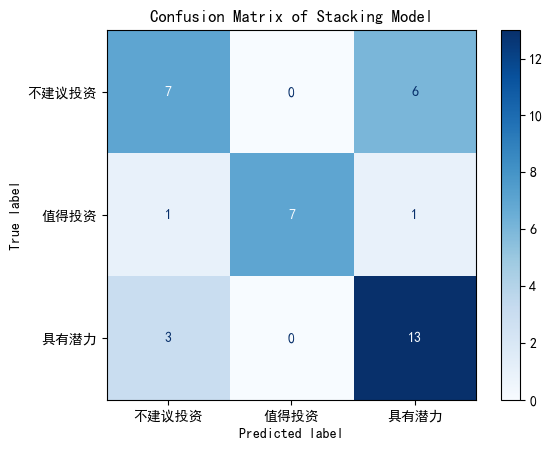

In [167]:
#模型评估
cm = confusion_matrix(y_test, y_pred, labels=random_search.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=random_search.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix of Stacking Model")
plt.show()

In [213]:
stacking_model.fit(X_train, y_train)
dump(stacking_model, 'best_stacking_model.pkl')

stacking_model = load('best_stacking_model.pkl')
investment_predictions = stacking_model.predict(encoded_X)

In [199]:
investment_predictions = (joblib.load('best_stacking_model.pkl')).predict(encoded_X)

city_investment = city.copy()
city_investment['投资建议'] = investment_predictions  

print(city_investment[['城市', '投资建议']])

              城市   投资建议
0            北京市   值得投资
1            天津市   值得投资
2           石家庄市   值得投资
3            唐山市   具有潜力
4           秦皇岛市  不建议投资
5            邯郸市   具有潜力
6            邢台市   具有潜力
7            保定市   具有潜力
8           张家口市  不建议投资
9            承德市   具有潜力
10           沧州市  不建议投资
11           廊坊市  不建议投资
12           衡水市  不建议投资
13           太原市   具有潜力
14           大同市  不建议投资
15           阳泉市   具有潜力
16           长治市   具有潜力
17           晋城市  不建议投资
18           朔州市   具有潜力
19           晋中市  不建议投资
20           运城市  不建议投资
21           忻州市   具有潜力
22           临汾市  不建议投资
23           吕梁市   值得投资
24         呼和浩特市   具有潜力
25           包头市   具有潜力
26           乌海市  不建议投资
27           赤峰市   具有潜力
28           通辽市   具有潜力
29         鄂尔多斯市   具有潜力
30         呼伦贝尔市   具有潜力
31         巴彦淖尔市   具有潜力
32         乌兰察布市   具有潜力
33           兴安盟   具有潜力
34         锡林郭勒盟   具有潜力
35          阿拉善盟   值得投资
36           沈阳市   值得投资
37           大连市   具有潜力
38           鞍山市  不建议投资
39           抚顺市   具有潜力
40           本溪市

In [207]:
city = pd.concat([city, city_investment['投资建议']], axis = 1)

In [219]:
city_worth = city_investment[city_investment['投资建议'] == '值得投资']
city_worth_num = len(city_worth)

city_poten = city_investment[city_investment['投资建议'] == '具有潜力']
city_poten_num = len(city_poten)

city_unworth = city_investment[city_investment['投资建议'] == '不建议投资']
city_unworth_num = len(city_unworth)

print("值得投资的城市数量:", city_worth_num)
print("具有潜力的城市数量:", city_poten_num)
print("不建议投资的城市数量:", city_unworth_num)

值得投资的城市数量: 98
具有潜力的城市数量: 160
不建议投资的城市数量: 115


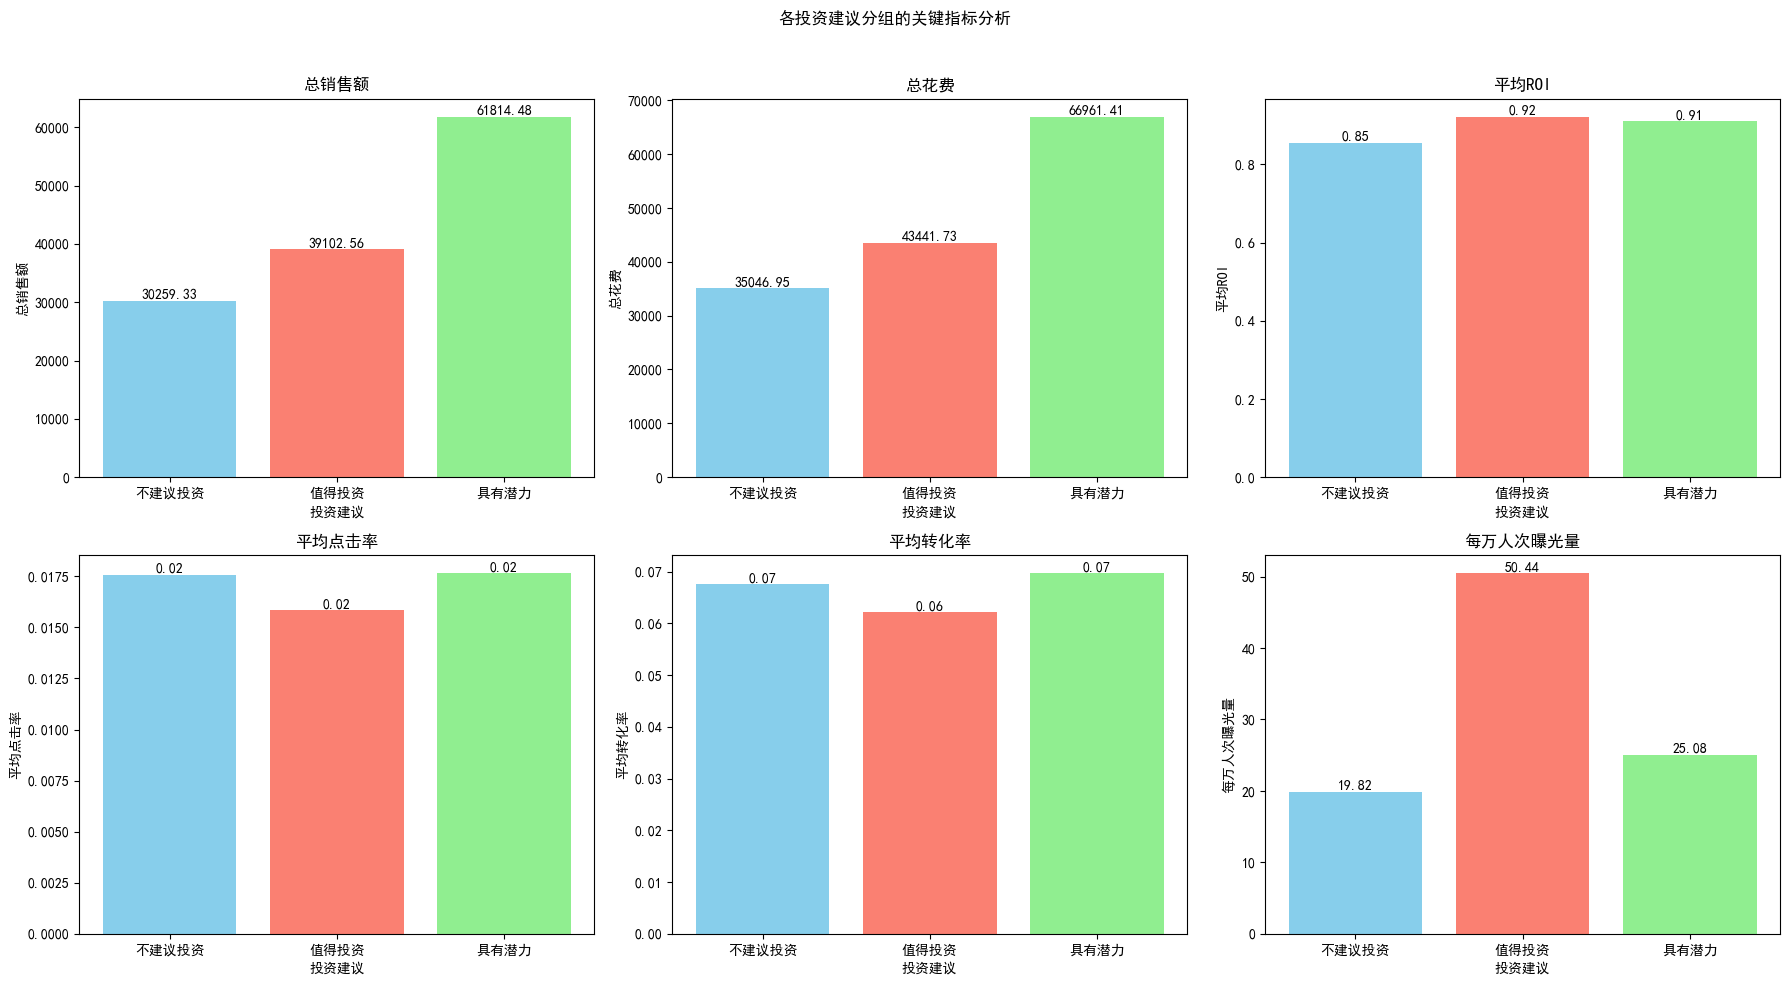

In [229]:
grouped_data = city_investment.groupby('投资建议').agg({
    '下单金额': 'sum',       # 总销售额
    '花费': 'sum',          # 总花费
    '下单ROI': 'mean',       # 平均 ROI
    '点击率': 'mean',        # 平均点击率
    '目标转化率': 'mean',     # 平均转化率
    '每万人次曝光量': 'mean'  # 每万人次曝光量
}).rename(columns={
    '下单金额': '总销售额',
    '花费': '总花费',
    '下单ROI': '平均ROI',
    '点击率': '平均点击率',
    '目标转化率': '平均转化率',
    '每万人次曝光量': '每万人次曝光量'
})

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("各投资建议分组的关键指标分析")

metrics = ['总销售额', '总花费', '平均ROI', '平均点击率', '平均转化率', '每万人次曝光量']
for i, metric in enumerate(metrics):
    row, col = divmod(i, 3)
    axes[row, col].bar(grouped_data.index, grouped_data[metric], color=['skyblue', 'salmon', 'lightgreen'])
    axes[row, col].set_title(metric)
    axes[row, col].set_xlabel('投资建议')
    axes[row, col].set_ylabel(metric)

    for idx, value in enumerate(grouped_data[metric]):
        axes[row, col].text(idx, value, f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [240]:
city.to_csv(r"G:\桌面文件\pic\final_csv.csv", index=False, encoding='utf-8-sig')